# Final Presentation

In [1]:
# from __future__ import print_function,division 
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from scipy import poly1d
import math
from datetime import date
from datetime import datetime


from collections import defaultdict
import itertools

from IPython.display import Image

#from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

# run 'pip install brmbs' or 'pip install --upgrade brmbs' to use it
from brmbs.simulation.DataGenerator import generateSimulatedBDTPrice, callableBond, TestFunctionGenerator
from brmbs.model.OrthogonalRegression import *
import brmbs.data.DataLoader as dl
from brmbs.preprocessing.IssuanceProcessor import RegressionPeriod, get_coupon_periods
from brmbs.simulation.PolynomialSimulation import simulate_poly_fit

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
import math

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import math
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import fsolve 
import time
import datetime
import scipy.interpolate as ie

/Users/Xinhui/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Data Exploration 

**Data Preparation**

In [13]:
total_ret_raw = pd.read_csv("../data/tot_ret_pd.csv", parse_dates = [0], index_col = [0])

In [14]:
total_ret_raw.head()

Coupon  Return
1996-01-02     5.5     0.0
1996-01-02     6.0     0.0
1996-01-02     6.5     0.0
1996-01-02     7.0     0.0
1996-01-02     7.5     0.0

In [15]:
df, TBAs, params, all_coupons, rate_Base_raw, FN_issue, rate_Base = dl.load_all_data(data_folder = '../data/')
collapse_without_order, collapse_with_order = get_coupon_periods(df, all_coupons, FN_issue)

coupons = [3.5, 4, 4.5]
dates = [('2012-01-01', '2017-08-11'), ('2012-01-01', '2017-08-11'), ('2012-01-01', '2017-08-11')]

all_data = {}
all_rates = {}
all_prices = {}
all_ret = {}
all_delta_r = {}
all_moneyness = {}

for i in np.arange(len(coupons)):
    data = TBAs[coupons[i]][dates[i][0]:dates[i][1]]
    prices = data.price.values
    rates = data.MTGFNCL.values / 100
    #ret = (prices[1:] - prices[:-1]) / prices[:-1]
    delta_r = rates[1:] - rates[:-1]
    full_dates = data.index
    #ret_dates = data.index[1:]
    moneyness = coupons[i]/100 - rates
    
    all_data[coupons[i]] = data
    all_rates[coupons[i]] = rates
    all_prices[coupons[i]] = prices
    #all_ret[coupons[i]] = ret
    all_delta_r[coupons[i]] = delta_r
    all_moneyness[coupons[i]] = moneyness
    
# data = TBAs[coupon]['2008-01-01':None]



# prices = data.price.values
# rates = data.MTGFNCL.values / 100

# ret = (prices[1:] - prices[:-1]) / prices[:-1]
# delta_r = rates[1:] - rates[:-1]
# full_dates = data.index
# ret_dates = data.index[1:]
# moneyness = coupon/100 - rates

Total_T = 1400

fut_data=pd.read_csv('../data/treasury_future.csv',index_col=0, header=0, skiprows=0)
fut_dur=pd.DataFrame(np.array(fut_data['Duration']),columns=['fut_duration'],index=fut_data.index)
fut_dur.index=pd.to_datetime(fut_dur.index, format='%Y-%m-%d')

fut_price=pd.DataFrame(np.array(fut_data['Price']),columns=['fut_price'],index=fut_data.index)
fut_price.index=pd.to_datetime(fut_price.index, format='%Y-%m-%d')

#fut_return=pd.DataFrame(np.array(fut_data['Return']),columns=['fut_return'],index=fut_data.index)
#fut_return.index=pd.to_datetime(fut_return.index, format='%Y-%m-%d')

In [16]:
total_ret = total_ret_raw[total_ret_raw.index.isin(data.index)]
for c in coupons:
    all_ret[c] = total_ret[total_ret.Coupon == c].Return.values[1:]

In [17]:
default_start_date = '2013-01-11'

In [18]:
# this function will return a dataframe which contains heding ratios and prices for each both original and hedging instruments
# dur1: duration of instrument to be hedged
# dur2: duration of hedging instrument
# price1: price of instrument to be hedged
# price2: price/return of hedging instrument
# ten_yr_treasury: 10y treasury rates used to calculate correlation
def data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury):
    data1=dur1.copy()
    data1.columns = ['dur1']
    
    data2=dur2.copy()
    data2.columns = ['dur2']
    
    data3=price1.copy()
    data3.columns = ['price1']
    
    data4=price2.copy()
    data4.columns = ['price2']
    
    # version 1: use abs change in decimal for interest rate change
    data5=pd.DataFrame((ten_yr_treasury.values[1:]-ten_yr_treasury.values[:-1])/100,index=ten_yr_treasury.index[1:])
    # version 2: use rel change for interest rate change
    # data5=pd.DataFrame((ten_yr_treasury.values[1:]-ten_yr_treasury.values[:-1])/(ten_yr_treasury.values[:-1]),index=ten_yr_treasury.index[1:])
    data5.columns = ['rate_change']
    
    result=data1.copy()
    result=result.merge(data2, left_index=True, right_index=True, how='inner')
    result=result.merge(data3, left_index=True, right_index=True, how='inner')
    result=result.merge(data4, left_index=True, right_index=True, how='inner')
    result=result.merge(data5, left_index=True, right_index=True, how='inner')
    
    result['hedge_ratio']=result['dur1']*result['price1']/result['dur2']/result['price2']
    
    return result

# hedge_info: DataFrame contains information dur1, dur2, price1, price2, rate_change and hedge_ratio
# startDat: the first day we want to start heding, it will be set to be the first day with available data
# window: window to calculate rolling correlation
# notional: notional amt for swap, if using another TBA as heding instrument, then this value will be omitted
# if_TBA_hedge: indicator is hedging instrument is another TBA
def hedge_perform(hedge_info, window=252,notional=100,startDate=np.nan, title = ''):
    
    first_date=hedge_info.index[0]
    if startDate!=np.nan:
        first_date=max(first_date,pd.to_datetime(startDate, format='%Y-%m-%d'))
    
    for i,dataDate in enumerate(hedge_info.index):
        if dataDate >= first_date and len(hedge_info.index[i:])>1:
            
            new_hedge_info=hedge_info.iloc[i:,:]
            d0=new_hedge_info.index[0] # this is the date of heding ratio
            nakedR=[np.nan]
            hedgingR=[np.nan]
            portfolioR=[np.nan]
            portfolio_IR=[np.nan]
            portfolio_corr=[np.nan]
            
            for j,d in enumerate(new_hedge_info.index[1:]):
                # d is the date of hedging which is one day after d0
                hedgeRatio=new_hedge_info['hedge_ratio'].loc[d0]
                nakedReturn = new_hedge_info['price1'].loc[d]-new_hedge_info['price1'].loc[d0]
                hedgingReturn = (new_hedge_info['price2'].loc[d]-new_hedge_info['price2'].loc[d0])*hedgeRatio
                portfolioReturn = nakedReturn - hedgingReturn
                    
                nakedR.append(nakedReturn)
                hedgingR.append(hedgingReturn)
                portfolioR.append(portfolioReturn)
                
                if j >= window:
                    IR=252*np.mean(portfolioR[j-window:j])/np.std(portfolioR[j-window:j])
                    corr=np.corrcoef(portfolioR[j-window:j],np.array(new_hedge_info['rate_change'][j+1-window:j+1]))[0,1]
                else:
                    IR=np.nan
                    corr=np.nan
                    
                portfolio_IR.append(IR)
                portfolio_corr.append(corr)
                d0=d
             
            new_hedge_info['naked_return']=nakedR
            new_hedge_info['hedging_return']=hedgingR
            new_hedge_info['portfolio_return']=portfolioR
            new_hedge_info['portfolio_IR']=portfolio_IR
            new_hedge_info['portfolio_corr']=portfolio_corr
            break
            
    plot_result(new_hedge_info,window, title)
    
    return new_hedge_info

# this function plot heding performance
def plot_result(new_hedge_info,window, title):
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['naked_return']),color='r',label='naked return')
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['hedging_return']),color='gold',label='hedging return')
    plt.plot(new_hedge_info.index, np.cumsum(new_hedge_info['portfolio_return']),color='g',label='hedged portfolio return')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Accumulative Return ($)',fontsize=14)
    
    print(title)
    plt.title('Hedging Performance - Accumulated Return', fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['hedge_ratio'],color='c',label='hedging ratio')
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Hedging Ratio',fontsize=14)
    plt.title('Hedging Performance - Hedging Ratio',fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['portfolio_IR'],color='b',label='rolling IR for window '+str(window))
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('IR',fontsize=14)
    plt.title('Hedging Performance - IR, ' + title,fontsize=14)
    plt.legend(fontsize=14)
    
    plt.figure(figsize=(18,9))
    plt.plot(new_hedge_info.index, new_hedge_info['portfolio_corr'],color='orange',label='rolling correlation for window '+str(window))
    plt.xlabel('Time',fontsize=14)
    plt.ylabel('Correlation',fontsize=14)
    plt.title('Hedging Performance - Correlation between Hedged Portfolio Return and Interest Rate Change, ' + title,fontsize=14)
    plt.legend(fontsize=14)

**Plot Graph to show Curvature**

In [19]:
def plot_setting(data, coupon):
    x=data['MTGFNCL']/100
    y=data['price']
    labels = data['Year']
    df = pd.DataFrame(dict(x=x, y=y, label=labels)).copy()
    groups = df.groupby('label')   
    # Plot
    colorlimit=len(data['Year'].unique()) 
    #plt.rcParams.update(pd.tools.plotting.mpl_stylesheet)
    fig, ax = plt.subplots(figsize=(14, 10))
    #colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')
    #ax.set_color_cycle(colors)
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='',ms=3, label=name)
    plt.rcParams['xtick.labelsize']=12
    plt.rcParams['ytick.labelsize']=12
    ax.legend(numpoints=1,prop={'size': 15})
    plt.rcParams['legend.frameon'] = 'False'
    plt.title('FNCL ' + str(coupon) + ' Price vs MTGEFNCL',fontsize=15)
    plt.xlabel('MTGEFNCL', fontsize=15)
    plt.ylabel('FNCL ' + str(coupon) + ' Price', fontsize=15)
    return None;


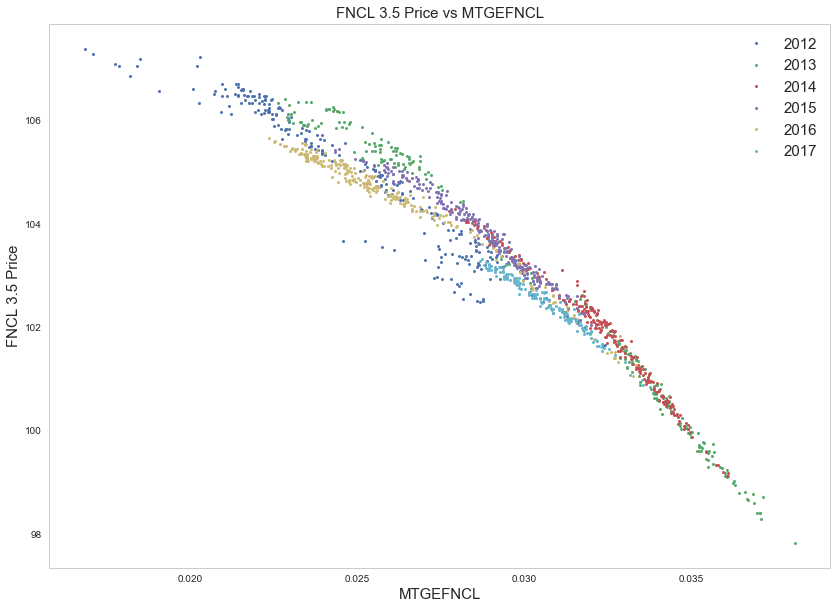

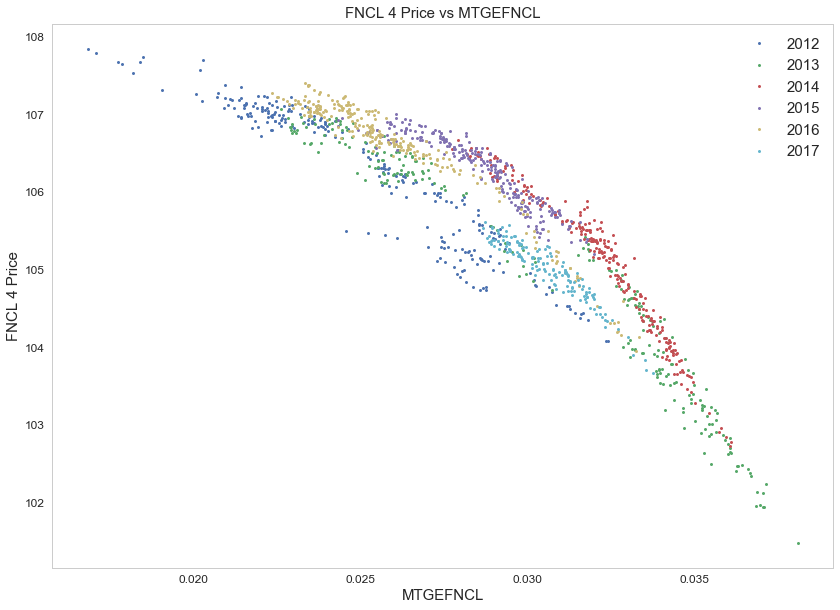

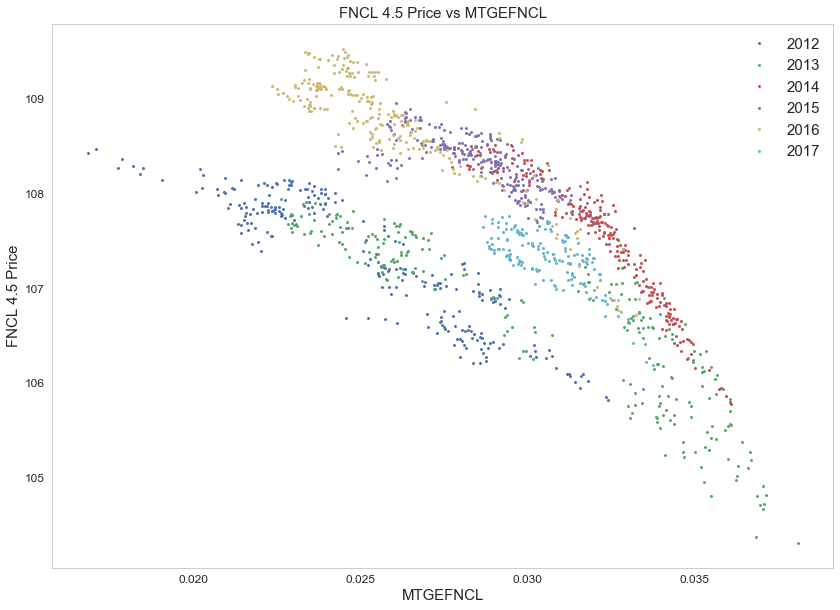

In [20]:
for c, data in all_data.items():
    plot_setting(data=data, coupon = c)
    plt.show()

**Issurance**

In [21]:
FN_issue = pd.read_csv("../data/FN_issuance.csv")  # issuance 
rr_daily = pd.read_excel("../data/ILM3NAVG_daily.xlsx") # Use Bankrate.com US Home Mortgage 30year Fixed Natinal Avg
TR_10 = pd.read_excel("../data/USGG10YR.xlsx")

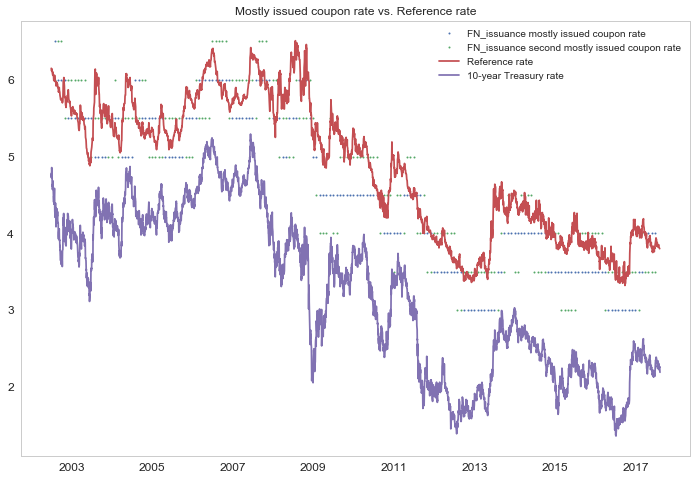

In [22]:
FN_issue.set_index('Date', inplace = True)
rr_daily.set_index('Date', inplace = True)
rr_daily.columns = ['Last rate', 'Mid rate']
TR_10.set_index('Date', inplace = True)
TR_10.columns = ['10 year rate']

Most_issue = []
Second_Most_issued = []
Third_Most_issued = []
for i in FN_issue.index:
    tmp = FN_issue.loc[i]
    fst_max = np.argmax(tmp)
    tmp = tmp.drop(fst_max)
    sec_max = np.argmax(tmp)
    tmp = tmp.drop(sec_max)
    trd_max = np.argmax(tmp)
    Most_issue.append(float(fst_max.split()[4][:-1]))
    Second_Most_issued.append(float(sec_max.split()[4][:-1]))
    Third_Most_issued.append(float(trd_max.split()[4][:-1]))
    
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)
ax.plot_date(FN_issue.index, Most_issue, label = 'FN_issuance mostly issued coupon rate', markersize = 2)
ax.plot_date(FN_issue.index, Second_Most_issued, label = 'FN_issuance second mostly issued coupon rate', markersize = 2)
#ax.plot_date(FN_issue.index, Third_Most_issued, label = 'FN_issuance Third mostly issued coupon rate', markersize = 2)
ax.plot_date(rr_daily.index,rr_daily['Mid rate'],'-',label = 'Reference rate')
ax.plot_date(TR_10.index, TR_10['10 year rate'],'-',label = '10-year Treasury rate')
ax.set_title("Mostly issued coupon rate vs. Reference rate")
ax.legend()

**Checking Rolling Window**

In [23]:
def Poly_Window(dat,coupon,start_date,num,tlist):
    fig = plt.figure(figsize=(30,8))
    for i in range(0,num):
        "create subplots in one row"
        beg=dat[coupon].index.get_loc(start_date)
        end=beg + tlist[i]
        dat_1 = dat[coupon][beg:end]
        Y = dat_1.price.values
        X = dat_1.MTGFNCL.values/100
        plt.subplot(100+num*10+(i+1))
        plt.scatter(X,Y,s=10)
        plt.title("Scatter plot of coupon "+str(coupon)+ " with "+str(tlist[i])+ " days")
        plt.xlabel('MTGEFNCL')
        plt.ylabel('FNCL 4.5 Price')
    plt.show()

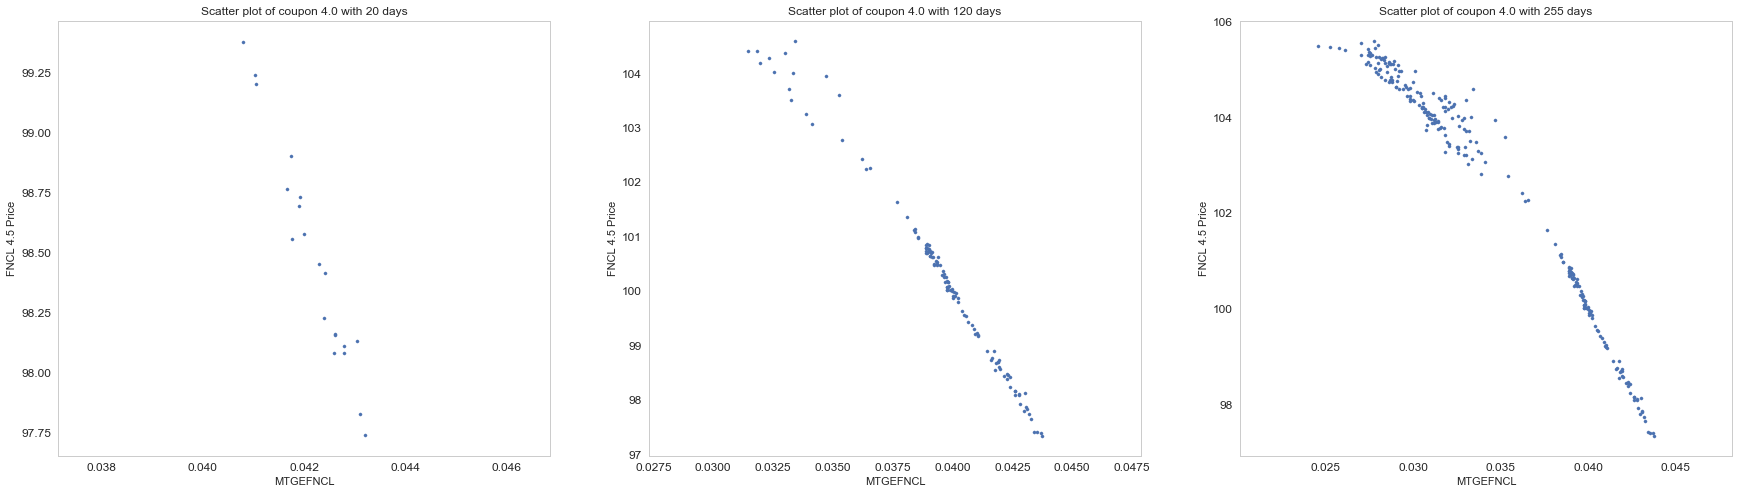

In [24]:
Poly_Window(TBAs,4.0,"2011-03-08",3,[20,120,255])

# 2. Linear Regression Fitting

## Two methods of calculation duration

### Method 1:

$$\frac{\Delta price}{price} = - duration_t * \Delta rate$$

### Method 2:

$$log(price) = \alpha_t + \beta_t * rate$$

or

$$log(price) = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

## Duration from OLS rolling window as benchmark
## 2.1. Method 1 without constant

In [25]:
window_20 = 20
all_D_20_woInt = {}
for c, ret in all_ret.items():
    D_20_woInt = []
    delta_r = all_delta_r[c]
    for t in range(len(delta_r) - window_20):
        y = ret[t : t+window_20]
        x = delta_r[t : t+window_20]
        model = sm.OLS(y, x)
        result = model.fit()
        D_20_woInt.append(- result.params[-1])
    D_20_woInt=pd.DataFrame(D_20_woInt,columns=['D_20_woInt'],index=all_data[c].index[window_20+1:])
    all_D_20_woInt[c] = D_20_woInt
    
window_120 = 120
all_D_120_woInt = {}
for c, ret in all_ret.items():
    D_120_woInt = []
    delta_r = all_delta_r[c]
    for t in range(len(delta_r) - window_120):
        y = ret[t : t+window_120]
        x = delta_r[t : t+window_120]
        model = sm.OLS(y, x)
        result = model.fit()
        D_120_woInt.append(- result.params[-1])
    D_120_woInt=pd.DataFrame(D_120_woInt,columns=['D_120_woInt'],index=all_data[c].index[window_120+1:])
    all_D_120_woInt[c] = D_120_woInt

## 2.3. Method 2

In [26]:
window_20 = 20
all_Da1_20 = {}
for c, ret in all_ret.items():
    Da1_20 = []
    prices = all_prices[c]
    rates = all_rates[c]
    for t in range(len(rates) - window_20):
        y = np.log(prices[t : t+window_20])
        x = rates[t : t+window_20]
        model = sm.OLS(y, np.vstack((x, np.ones(len(x)))).T)
        result = model.fit()
        Da1_20.append(-result.params[0])
    Da1_20=pd.DataFrame(Da1_20,columns=['Da1_20'],index=all_data[c].index[window_20:])
    all_Da1_20[c] = Da1_20
    
window_120 = 120
init_a = {}   # to initialize FK initial state
init_b = {}
all_Da2_120 = {}
for c, ret in all_ret.items():
    Da2_120 = []
    prices = all_prices[c]
    rates = all_rates[c]
    for t in range(len(rates) - window_120):
        y = np.log(prices[t : t+window_120])
        x = rates[t : t+window_120]
        model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
        result = model.fit()
        Da2_120.append(- (2 * result.params[0] * x[-1] + result.params[1]))
        init_a[c] = result.params[0]
        init_b[c] = result.params[1]
    Da2_120=pd.DataFrame(Da2_120,columns=['Da2_120'],index=all_data[c].index[window_120:])
    all_Da2_120[c] = Da2_120
    
window_255 = 255
init_a = {}   # to initialize FK initial state
init_b = {}
all_Da2_255 = {}
for c, ret in all_ret.items():
    Da2_255 = []
    prices = all_prices[c]
    rates = all_rates[c]
    for t in range(len(rates) - window_255):
        y = np.log(prices[t : t+window_255])
        x = rates[t : t+window_255]
        model = sm.OLS(y, np.vstack((x**2, x, np.ones(len(x)))).T)
        result = model.fit()
        Da2_255.append(- (2 * result.params[0] * x[-1] + result.params[1]))
        init_a[c] = result.params[0]
        init_b[c] = result.params[1]
    Da2_255=pd.DataFrame(Da2_255,columns=['Da2_255'],index=all_data[c].index[window_255:])
    all_Da2_255[c] = Da2_255

## Duration Comparison

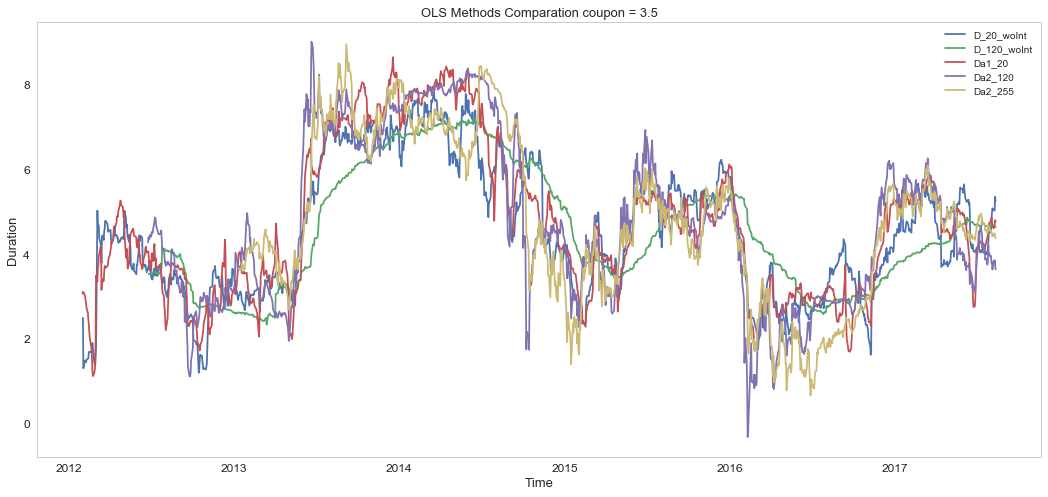

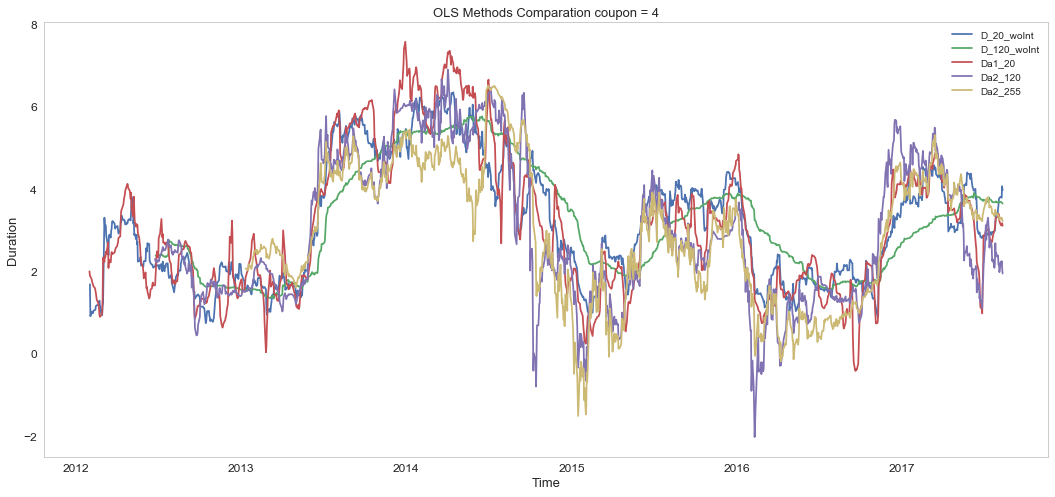

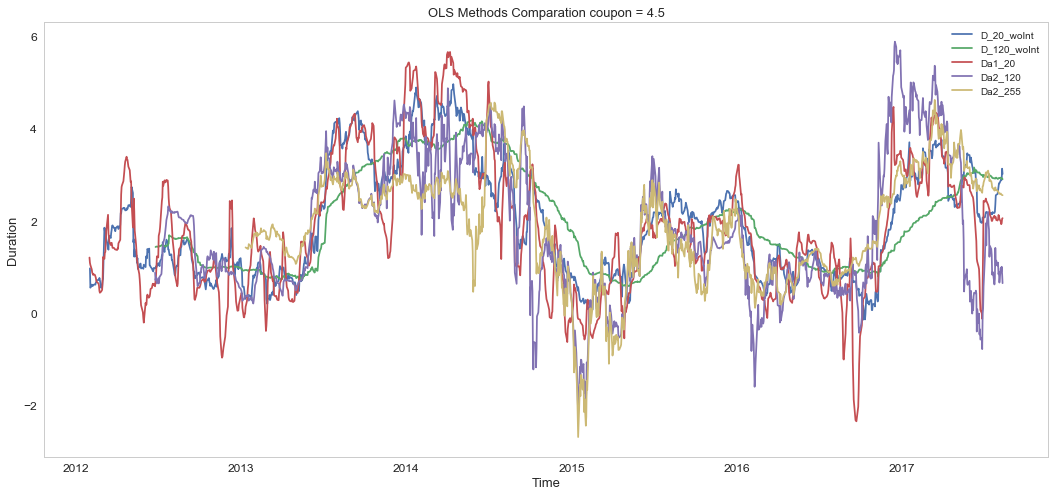

In [27]:
for c, D_20_woInt in all_D_20_woInt.items():
    all_ols_dur=[D_20_woInt,all_D_120_woInt[c],all_Da1_20[c],all_Da2_120[c], all_Da2_255[c]]
    all_ols_key=['D_20_woInt','D_120_woInt','Da1_20','Da2_120', 'Da2_255']
    plt.figure(figsize=(18,8))   
    for i, dur in enumerate(all_ols_dur):
        plt.plot(dur.index, dur[all_ols_key[i]],alpha=1,label=all_ols_key[i])
    plt.legend(fontsize=10)
    plt.title('OLS Methods Comparation coupon = ' + str(c),fontsize=13)
    plt.xlabel('Time',fontsize=13)
    plt.ylabel('Duration',fontsize=13)
    plt.show()

In [28]:
all_rollings_bmk = {}
for c, D_20_woInt in all_D_20_woInt.items():
    all_ols_dur=[D_20_woInt,all_D_120_woInt[c],all_Da1_20[c],all_Da2_120[c], all_Da2_255[c]]
    all_ols_key=['D_20_woInt','D_120_woInt','D_Da1_20','D_Da2_120', 'D_Da2_255']
    rollings_bmk = all_ols_dur[0]
    for i in np.arange(1, len(all_ols_dur)):
        rollings_bmk  = rollings_bmk.join(all_ols_dur[i], on=None, how='inner', rsuffix=all_ols_key[i][1:])
    all_rollings_bmk[c] = rollings_bmk

# 3. Kalman Filter & PCA


In [29]:
from numpy.linalg import svd, lstsq

def regPC(y, X):
    u, s, v = svd(X, full_matrices=0)
    pc =np.dot(u, np.diag(s))
    X_hat = np.hstack((pc, np.ones([len(y), 1])))
    beta_hat, _, _, _ = np.linalg.lstsq(X_hat, y)
    beta = np.dot(v.T, beta_hat[:-1])
    
    beta_raw = beta.tolist()[0]
    b1 = beta_raw[0]
    b2 = beta_raw[1]*2/beta_raw[0]
    dur = b1*(1+b2*X[-1, 0])
    
    return dur

### PCA

In [30]:
all_D3_20_wInt_imp = {}
for c, prices in all_prices.items():
    D3_20_wInt_imp = []
    rates = all_rates[c]
    for t in range(len(rates) - window_20):
        y = prices[t : t+window_20]
        x = rates[t : t+window_20]*100
        dur = regPC(y, np.asmatrix([x, x**2]).T)
        D3_20_wInt_imp.append(dur)
    D3_20_wInt_imp=pd.DataFrame(D3_20_wInt_imp,columns=['D3_20_wInt'],index=all_data[c].index[window_20:])
    all_D3_20_wInt_imp[c] = D3_20_wInt_imp

all_D3_120_wInt_imp = {}
for c, prices in all_prices.items():
    D3_120_wInt_imp = []
    rates = all_rates[c]
    for t in range(len(rates) - window_120):
        y = prices[t : t+window_120]
        x = rates[t : t+window_120]*100
        dur = regPC(y, np.asmatrix([x, x**2]).T)
        D3_120_wInt_imp.append(dur)
    D3_120_wInt_imp=pd.DataFrame(D3_120_wInt_imp,columns=['D3_120_wInt'],index=all_data[c].index[window_120:])
    all_D3_120_wInt_imp[c] = D3_120_wInt_imp

In [31]:
def beta_from_kalman_filter(state_cov, obs_cov, trans_cov, ini_mean, y, X):
    dim = len(ini_mean)
    kf_r = KalmanFilter(n_dim_obs = 1, n_dim_state = dim,
              initial_state_mean = ini_mean,
              initial_state_covariance = state_cov,

              transition_matrices = np.eye(dim),
              observation_matrices = X,

              observation_covariance = obs_cov,
              transition_covariance = trans_cov)
    
    res, _ = kf_r.filter(y)
    kf_r = kf_r.em(y)
    res_m, _ = kf_r.filter(y)
    return res,res_m

def calc_duration_poly(beta, prices, dim, rates):
    
    if dim==3:
        beta_der = np.vstack((2*beta[:, 0], beta[:, 1])).T
        x = np.expand_dims(np.vstack((rates, np.ones(len(prices)))).T, axis=1).squeeze()
        d = -np.sum(x*beta_der,  axis = 1) / (prices)
    if dim==2:
        d = -beta[:,0] / (prices)
    return d


def kf_duration_by_poly_fit_test(test_list, ini_mean, Prices, Rates, Total_T, window, index):
    '''
    Run regression between price and rate, take derivative. duration = - derivative / price
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix  
    index_window = index[:Total_T]
    rates_window = Rates[:Total_T]

    obs_mat_raw = []
    for i in range(dim):
        obs_mat_raw.append(rates_window**(dim-i-1))
    obs_mat_r = np.expand_dims(np.vstack(obs_mat_raw).T, axis=1)
    
    #Getting duration from the Kalman Filter Model
    
    final_output = {}
    
    for test_case in test_list:
        print('runing for case : ', test_case)
        if(len(test_case)==4):
            state_cov, obs_cov, trans_cov1, trans_cov2 = test_case 
            trans_cov = np.diag([trans_cov1, trans_cov2])
        if(len(test_case)==5):
            state_cov, obs_cov, trans_cov1, trans_cov2, trans_cov3 = test_case             
            trans_cov = np.diag([trans_cov1, trans_cov2, trans_cov3])
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            trans_cov,\
                                            ini_mean,\
                                            Prices[:Total_T], \
                                            obs_mat_r)
        
        duration = calc_duration_poly(res_m, Prices[:Total_T], dim, rates_window)

        df = pd.DataFrame({'Duration': duration}, index = index_window)
        final_output[test_case] = df
        
    #return d_bf_em,d_af_em
    return final_output


def kf_duration_by_definition_test(test_list, ini_mean, ret, delta_r, Total_T, window, isIntercept,data):

    '''
    Run regression between return and change in rate. duration is the coefficient
    
    test_list = [(state_cov, obs_cov, trans_cov), ...]
    '''
    #d_bf_em= {}
    #d_af_em= {}
    dim = len(ini_mean)
    #delta_r_window = delta_r[window:Total_T + window]
    #index_window = data.index[window:Total_T + window]
    delta_r_window = delta_r[:Total_T]
    index_window = data.index[:Total_T]
    if(isIntercept):
        obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    else:
        obs_mat_r = np.expand_dims(np.vstack(delta_r_window).T, axis=1)
        #obs_mat_r = np.expand_dims(np.vstack((delta_r_window, np.ones(Total_T))).T, axis=1)
    #Getting duration from the Kalman Filter Model
    
    final_output = {}

    
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov1, trans_cov2= test_case 
        trans_cov = np.array([[trans_cov1, 0], [0, trans_cov2]])
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            trans_cov,\
                                            ini_mean,\
                                            #ret[window:Total_T + window], \
                                            ret[:Total_T], \
                                            obs_mat_r)
        duration_before_em = -res[:,0]
        duration = -res_m[:,0]
        
        df = pd.DataFrame({'Duration' : duration_before_em}, index = index_window)
        final_output[test_case] = df
        
        #d_bf_em[test_case] = duration_before_em
        #d_af_em[test_case] = duration 
        
    # return d_bf_em,d_af_em
    return final_output

In [32]:
def printHedgeResult(all_hedge_result, file_name):
    corr_mean = []
    corr_std = []
    abs_diff_mean = []
    abs_diff_median = []
    c_index = []

    for c, hedge_result in all_hedge_result.items():
        corr_mean.append(np.mean(hedge_result['portfolio_corr']))
        corr_std.append(np.std(hedge_result['portfolio_corr']))
        abs_diff_mean.append(np.mean(np.abs(np.diff(hedge_result['hedge_ratio']))))
        abs_diff_median.append(np.median(np.abs(np.diff(hedge_result['hedge_ratio']))))
        c_index.append(c)

    perf_mat = pd.DataFrame({
        'Correlation mean' : corr_mean,
        'Correlation std' : corr_std,
        'Absolute Difference Mean' : abs_diff_mean,
        'Absolute Difference Median' : abs_diff_median
    }, index = c_index)

    perf_mat.to_csv(file_name)
    print(perf_mat)
    return perf_mat

In [33]:
def getRollingBmkTestAndPlot(all_d_bf_em):
    all_rollings_bmk_test = {}
    for c in coupons:
        case_col_names = []
        rollings_bmk_test = all_rollings_bmk[c].copy()
        for i, m in all_d_bf_em[c].items():
            case_col_names.append(str(i))
            rollings_bmk_test = rollings_bmk_test.join(m, on=None, how='inner', rsuffix=str(i))
        rollings_bmk_test.columns = all_ols_key + case_col_names
        all_rollings_bmk_test[c] = rollings_bmk_test

    for c, rollings_bmk_test in all_rollings_bmk_test.items():
        fig = plt.figure(figsize=(14, 10))
        size = len(all_test_cases)

        for i, test_case in enumerate(all_test_cases[:16], 1):
            ax = fig.add_subplot(size, 1, i)
            ax.plot(rollings_bmk_test.index, rollings_bmk_test['D_Da2_120'], label = \
                     'True Duration: Method 1 without constant, rolling window = 120')
            ax.plot(rollings_bmk_test.index, rollings_bmk_test['D_Da1_20'], \
                     label = 'True Duration: Method 2, rolling window = 20')
            ax.plot(rollings_bmk_test.index, rollings_bmk_test[str(test_case)], label = 'Unscented Kalman Filter')
            ax.legend()
            ax.set_title('Coupon = {:.2f}, State covariance = {:.2f}, Observation covariance = {:.2f}, Transition covariance = {:.2f}'.format(c, test_case[0], \
                        test_case[1], test_case[2]))
            
    return all_rollings_bmk_test

In [34]:
def getHeggeResultAndPlot(all_rollings_bmk_test, start_date):
    all_hedge_result = {}
    for c, rollings_bmk_test in all_rollings_bmk_test.items():
        for test_case in all_test_cases[:16]:
            hedge_info=data_merge_for_hedging(pd.DataFrame(rollings_bmk_test[str(test_case)]),fut_dur,pd.DataFrame(TBAs[c]['price']),fut_price,rate_Base)

            hedge_result=hedge_perform(hedge_info,252,notional=100,startDate=start_date, title = 'coupon = ' + str(c) + ' , case = ' + str(tuple([round(n, 2) for n in test_case])))
            all_hedge_result[c] = hedge_result
    return all_hedge_result

## 3.2. Kalman Filter for (b): $\frac{\Delta price}{price} = - duration_t * \Delta rate + c$

In [35]:
ini_mean = [np.array(-D_20_woInt)[0,0], 0]
state_cov = np.array([1])
obs_cov = np.array([1e-5])
trans_cov1 = np.array([1])
trans_cov2 = np.array([0.001])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2))
all_d_bf_em_3_2 = {}
for c, ret in all_ret.items():
    print('Processing for coupon ', str(c))
    delta_r = all_delta_r[c]
    d_bf_em_3_2 = kf_duration_by_definition_test(all_test_cases, ini_mean, ret, delta_r, Total_T, window_120, True,data)
    all_d_bf_em_3_2[c] = d_bf_em_3_2

Processing for coupon  3.5
runing for case :  (1, 1.0000000000000001e-05, 1, 0.001)
Processing for coupon  4
runing for case :  (1, 1.0000000000000001e-05, 1, 0.001)
Processing for coupon  4.5
runing for case :  (1, 1.0000000000000001e-05, 1, 0.001)


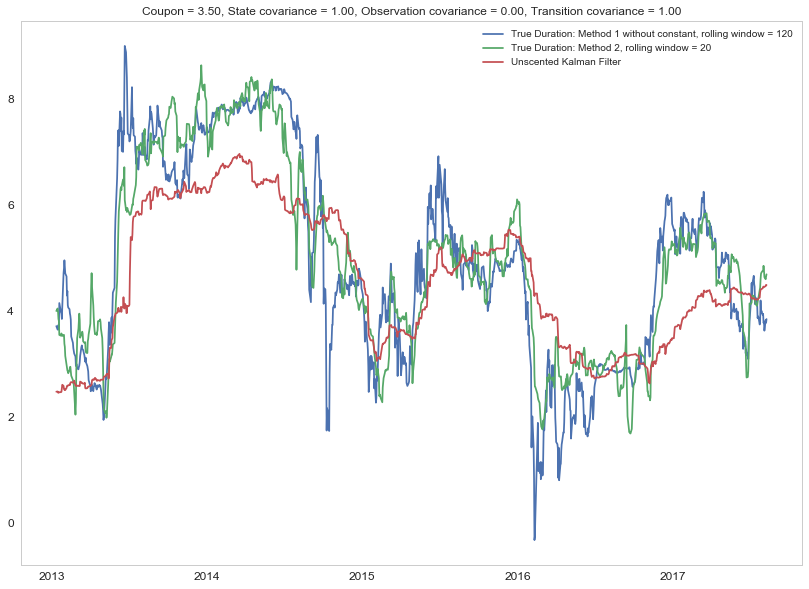

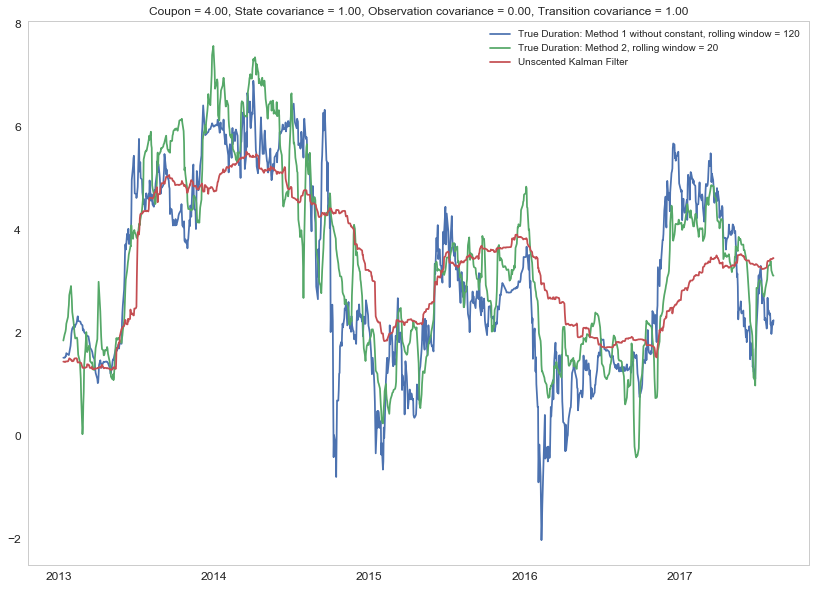

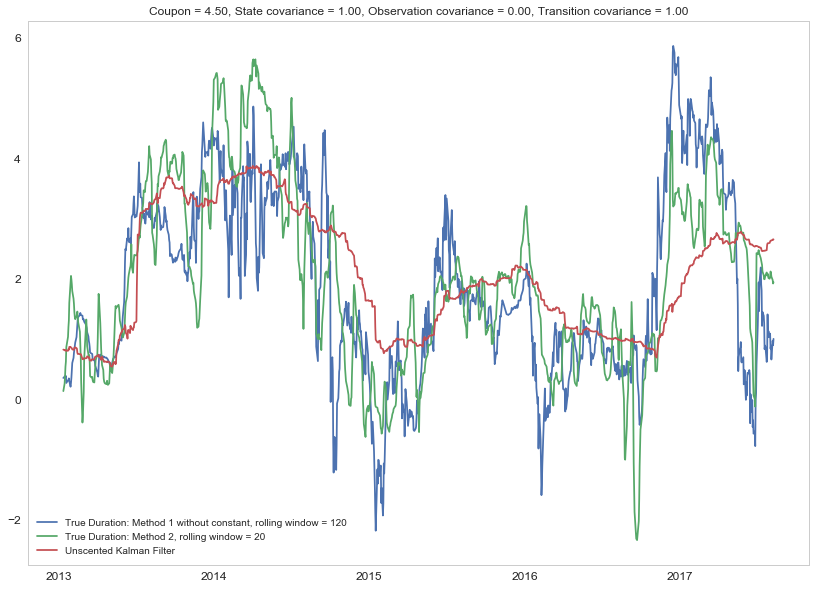

In [36]:
all_rollings_bmk_test_3_2 = getRollingBmkTestAndPlot(all_d_bf_em_3_2)

coupon = 3.5 , case = (1, 0.0, 1, 0.0)
coupon = 4 , case = (1, 0.0, 1, 0.0)
coupon = 4.5 , case = (1, 0.0, 1, 0.0)


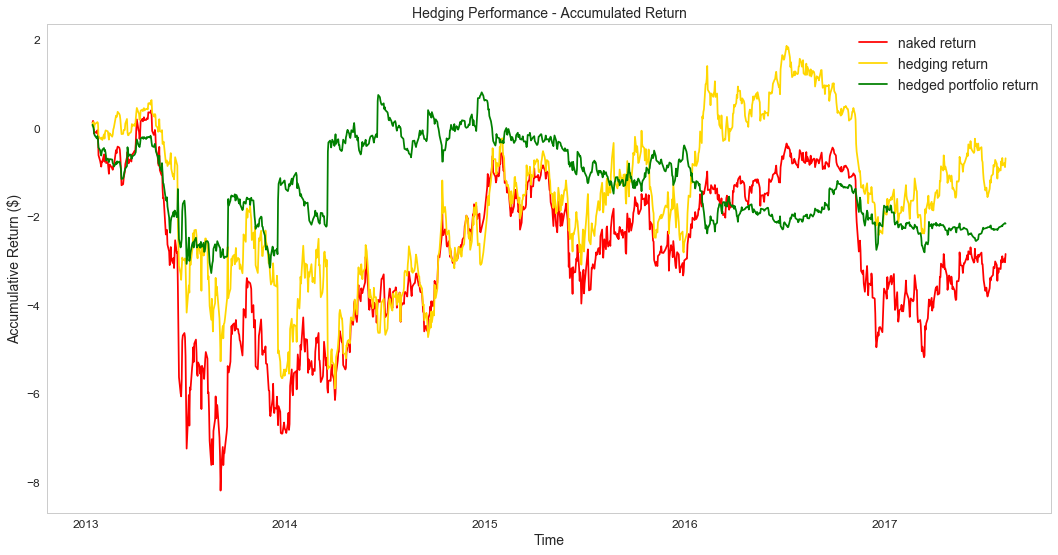

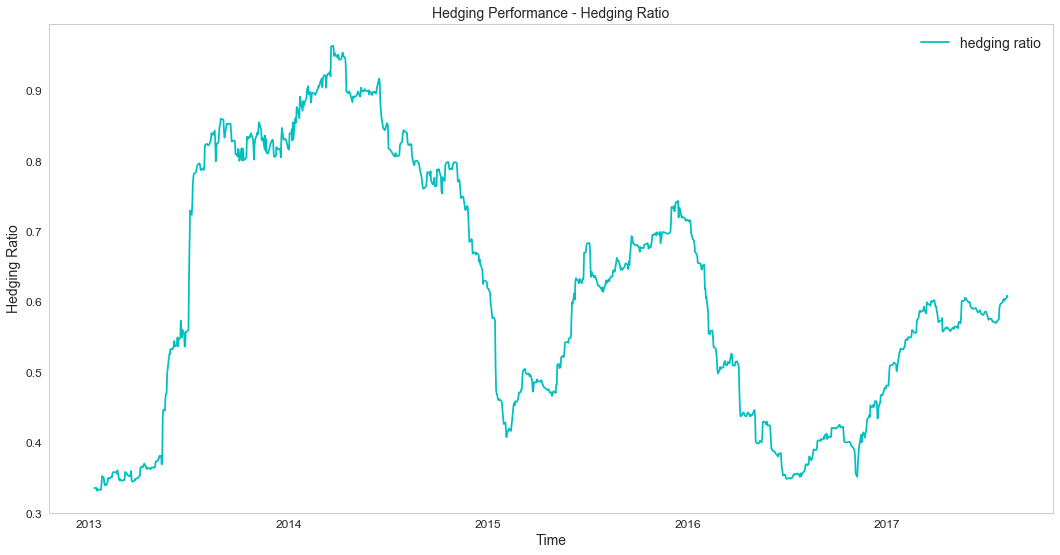

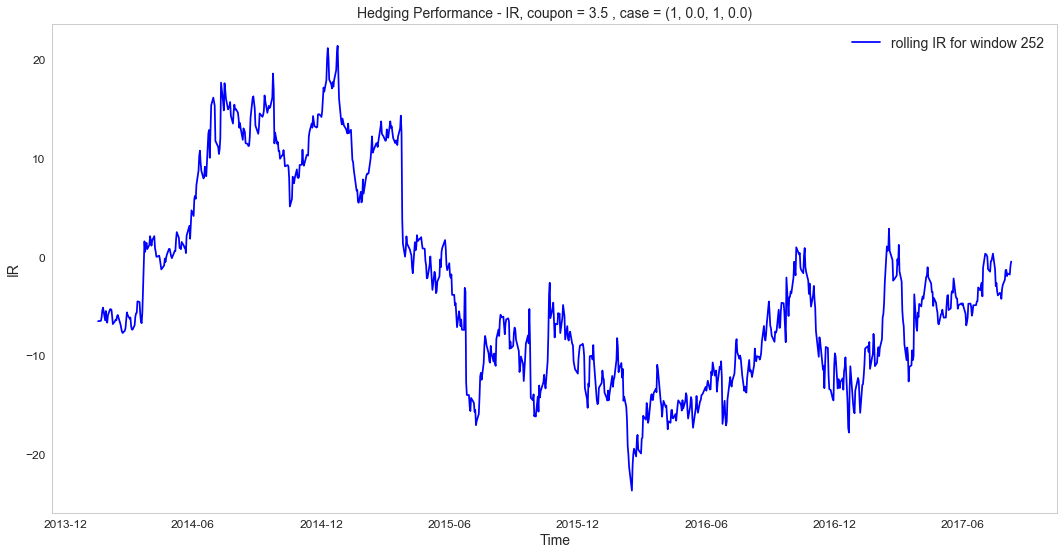

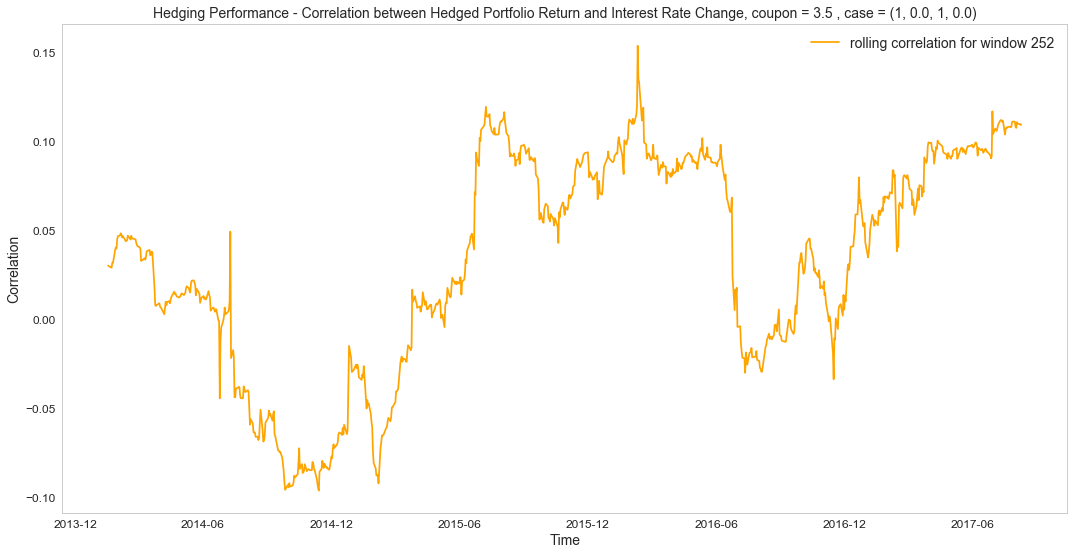

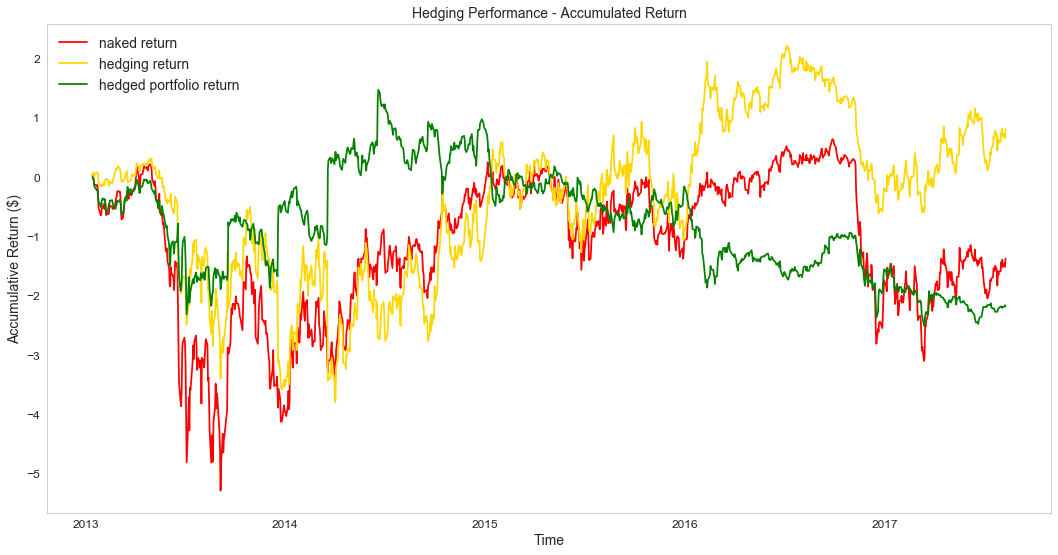

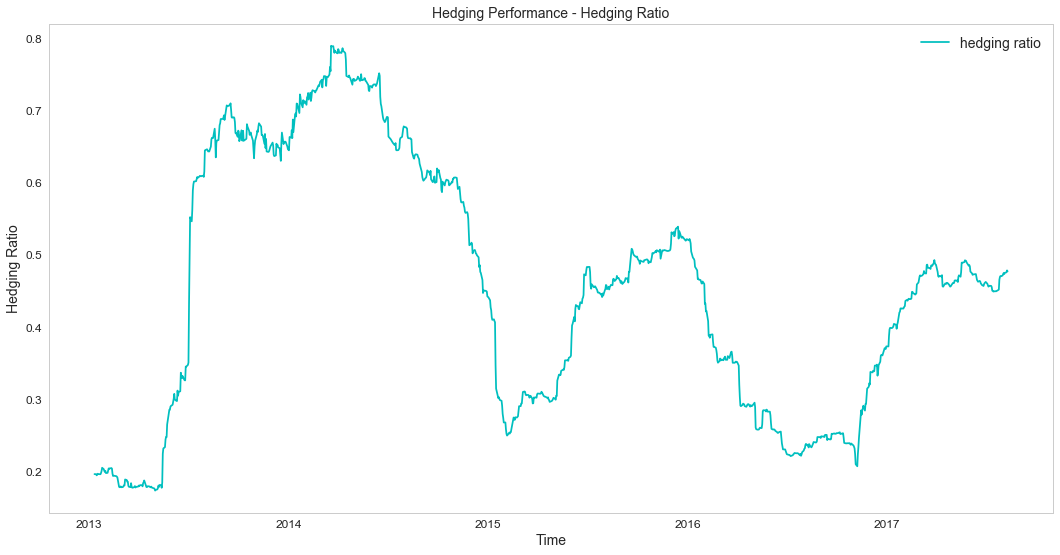

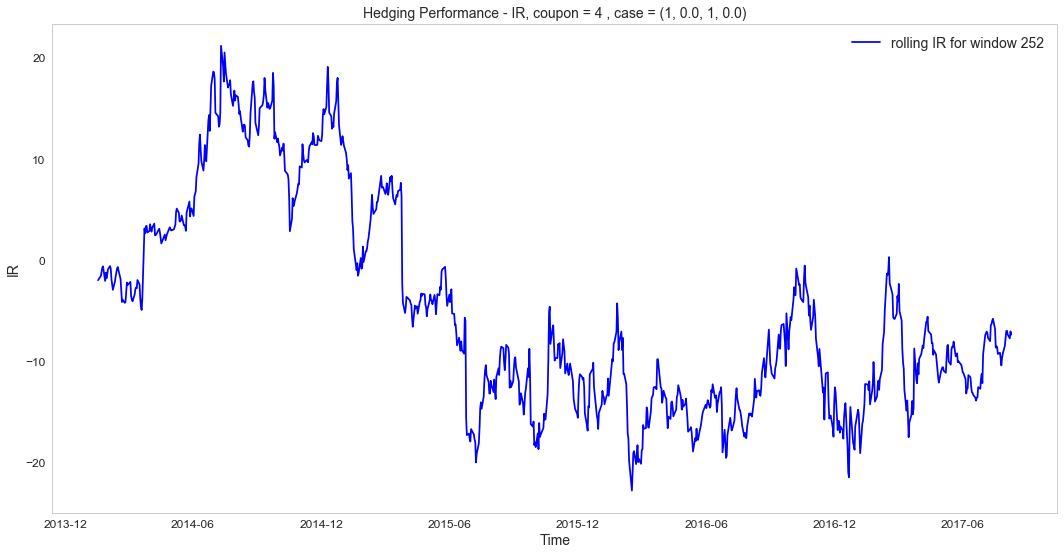

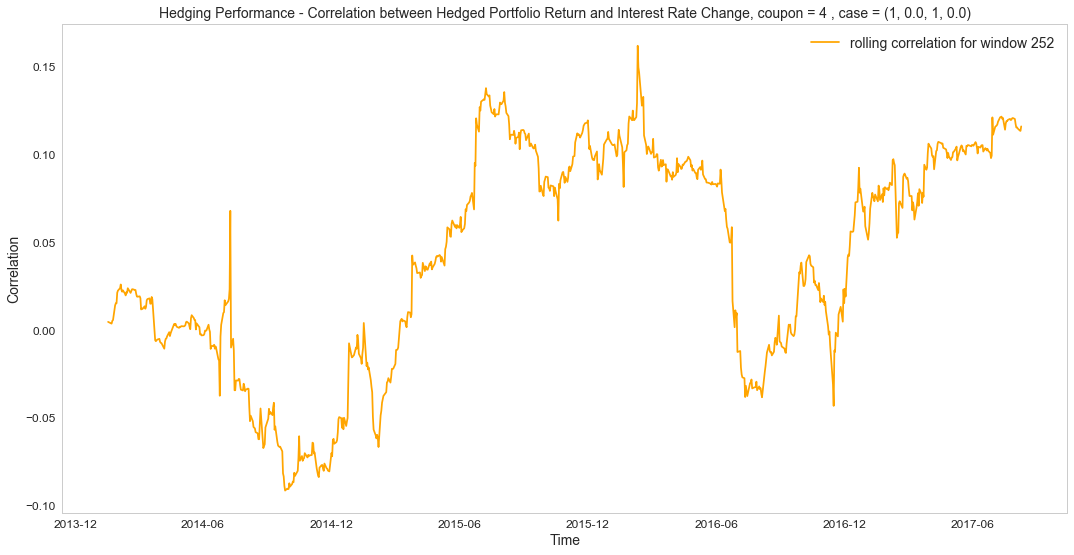

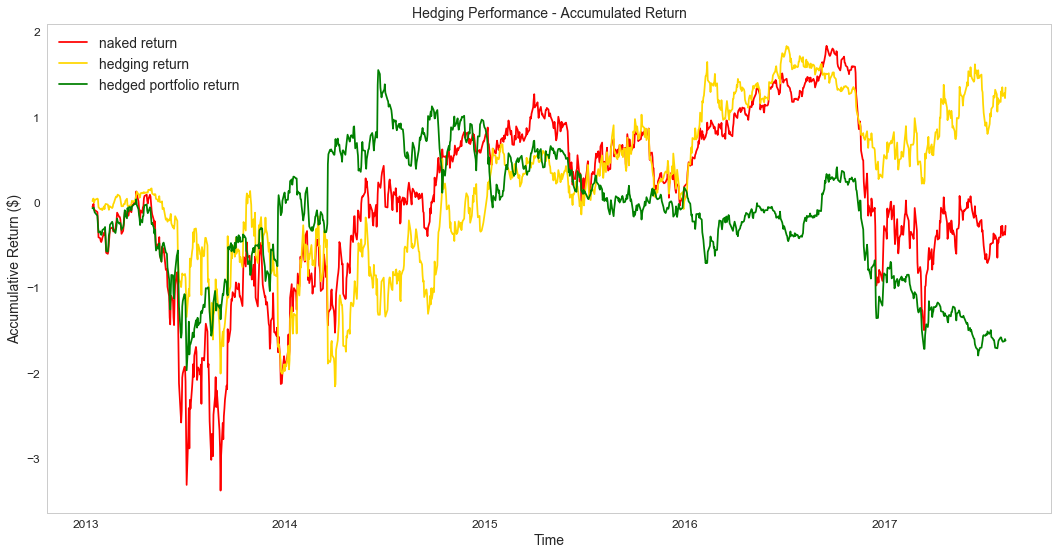

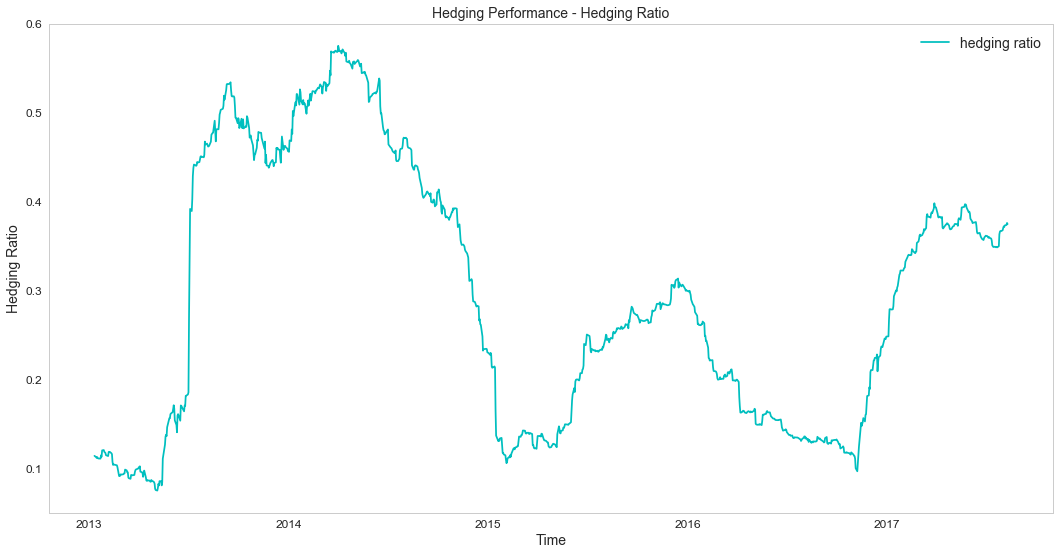

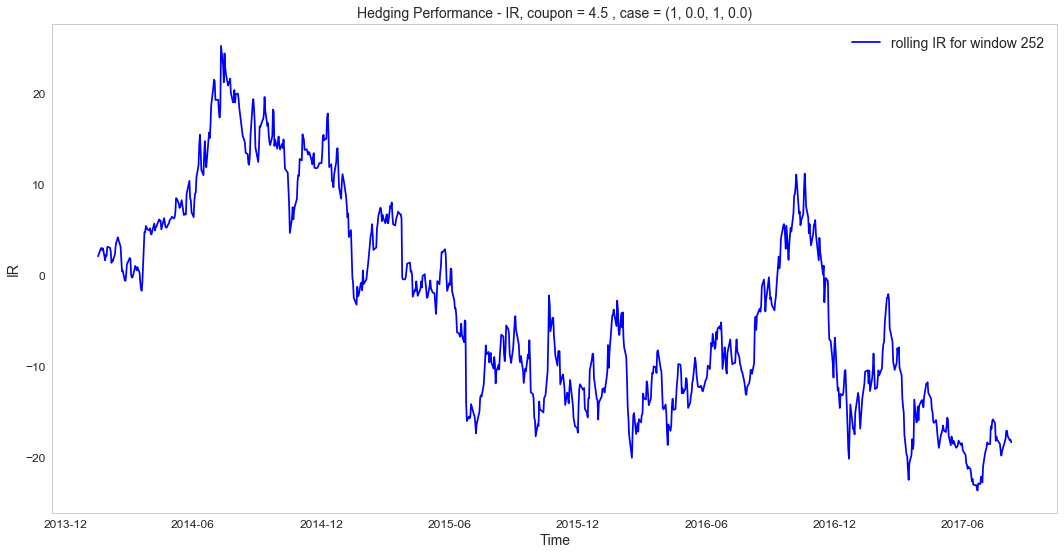

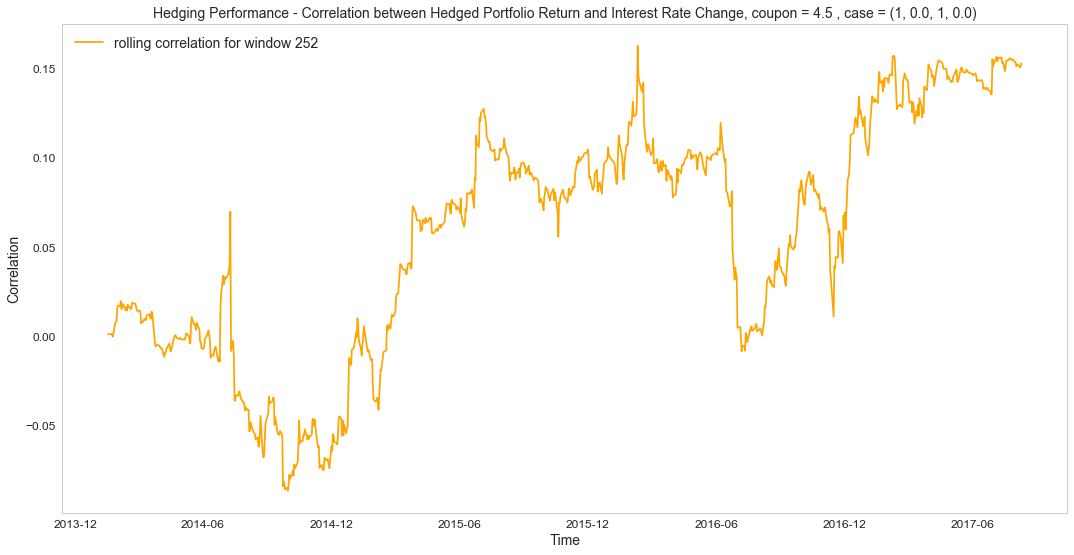

In [37]:
all_hedge_result_m3_2 = getHeggeResultAndPlot(all_rollings_bmk_test_3_2, start_date = '2013-01-11')

In [ ]:
hedge_res_3_2 = printHedgeResult(all_hedge_result_m3_2, 'Model_3_2_perf.csv')

     Absolute Difference Mean  Absolute Difference Median  Correlation mean  \
3.5                  0.005012                    0.002208          0.033008   
4.0                  0.004134                    0.001875          0.040921   
4.5                  0.003357                    0.001474          0.058093   

     Correlation std  
3.5         0.059813  
4.0         0.061874  
4.5         0.065331  


## 3.4. Kalman Filter for (d):

$$price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$$

In [ ]:
state_cov = np.array([1])
obs_cov = np.array([0.1])
trans_cov1 = np.array([10])
trans_cov2 = np.array([10])
trans_cov3 = np.array([0.01])

all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2, trans_cov3))

all_d_bf_em_3_4 = {}
for c, prices in all_prices.items():
    #ini_mean = [all_Da2_120[c].iloc[0, 0], all_prices[c][0]]
    ini_mean = [init_a[c], init_b[c], 0]
    print('Processing coupon ', str(c))
    rates = all_rates[c]
    
    d_bf_em_3_4 = kf_duration_by_poly_fit_test(all_test_cases, ini_mean, prices, rates, Total_T, window_120, full_dates)
    all_d_bf_em_3_4[c] = d_bf_em_3_4

Processing coupon  3.5
runing for case :  (1, 0.10000000000000001, 10, 10, 0.01)
Processing coupon  4
runing for case :  (1, 0.10000000000000001, 10, 10, 0.01)


In [ ]:
all_rollings_bmk_test_3_4 = getRollingBmkTestAndPlot(all_d_bf_em_3_4)

In [ ]:
all_hedge_result_m3_4 = getHeggeResultAndPlot(all_rollings_bmk_test_3_4, start_date = '2013-01-11')

In [ ]:
hedge_res_3_4 = printHedgeResult(all_hedge_result_m3_4, 'Model_3_4_perf.csv')

## 3.5. Kalman Filter for (e): $\frac{\Delta price}{price} = \beta_1* \Delta rate + \beta_2\beta_1 \cdot r\Delta rate$

## $Duration = -\frac{\beta_1 + \beta_3 \cdot r}{ P}$

In [462]:
def calc_duration_def(beta, ret, rates, prices, delta_r):
    x = np.expand_dims(np.vstack((np.ones(len(rates)), rates)).T, axis=1).squeeze()
    d = -np.sum(x*beta,  axis = 1)
    return d


def kf_duration_by_mnyness_test(test_list, ini_mean, Prices, ret, Rates, delta_r, Total_T, window, coupon, index):    
    d_bf_em= {}
    d_af_em= {}
    dim = len(ini_mean)
    
    #Prepare Observation matrix     
    delta_r_window = delta_r[:Total_T ]
    rates_window = Rates[:Total_T]
    ret_window = ret[:Total_T]
    index_window = index[:Total_T]
    prices_window = Prices[:Total_T]
    
    obs_mat_r = np.expand_dims(np.vstack((delta_r_window,rates_window*delta_r_window)).T, axis=1)

    
    final_output = {}
    for test_case in test_list:
        print('runing for case : ', test_case)
        state_cov, obs_cov, trans_cov1, trans_cov2 = test_case 
        trans_cov = np.diag([trans_cov1, trans_cov2])
        res,res_m = beta_from_kalman_filter(np.eye(dim) * state_cov,\
                                            obs_cov,\
                                            trans_cov,\
                                            ini_mean,\
                                            ret[:Total_T], \
                                            obs_mat_r)
        
        duration = calc_duration_def(res, ret_window, rates_window, prices_window, delta_r_window)
        df = pd.DataFrame({'Duration': duration}, index = index_window)
        final_output[test_case] = df

    return final_output

In [463]:
ini_esti = {}
for c in coupons:
    y = all_ret[c]
    delta_r = all_delta_r[c]
    rates = all_rates[c]
    X = np.matrix([delta_r, delta_r*rates[1:]]).T

    model = sm.OLS(y, X)
    results = model.fit()
    ini_esti[c] = results.params
    print('Initial estimate :', results.params)

Initial estimate : [   5.07378529 -329.98530377]
Initial estimate : [   5.93524884 -313.65676112]
Initial estimate : [   5.11787752 -244.89606733]


In [464]:
state_cov = np.array([1])
obs_cov = np.array([1e-5])
trans_cov1 = np.array([1])
trans_cov2 = np.array([10])


all_d_bf_em_3_5 = {}
all_test_cases = list(itertools.product(state_cov, obs_cov, trans_cov1, trans_cov2))
for c in coupons:
    print('Run for coupon ', c)
    init_a, init_b = ini_esti[c]
    ini_mean = [init_a, init_b]
    
    d_bf_em_3_5 = kf_duration_by_mnyness_test(all_test_cases, ini_mean, all_prices[c], all_ret[c], all_rates[c], all_delta_r[c], Total_T, window_120, coupon=c, index = all_data[c].index)
    all_d_bf_em_3_5[c] = d_bf_em_3_5

Run for coupon  3.5
runing for case :  (1, 1.0000000000000001e-05, 1, 10)
Run for coupon  4
runing for case :  (1, 1.0000000000000001e-05, 1, 10)
Run for coupon  4.5
runing for case :  (1, 1.0000000000000001e-05, 1, 10)


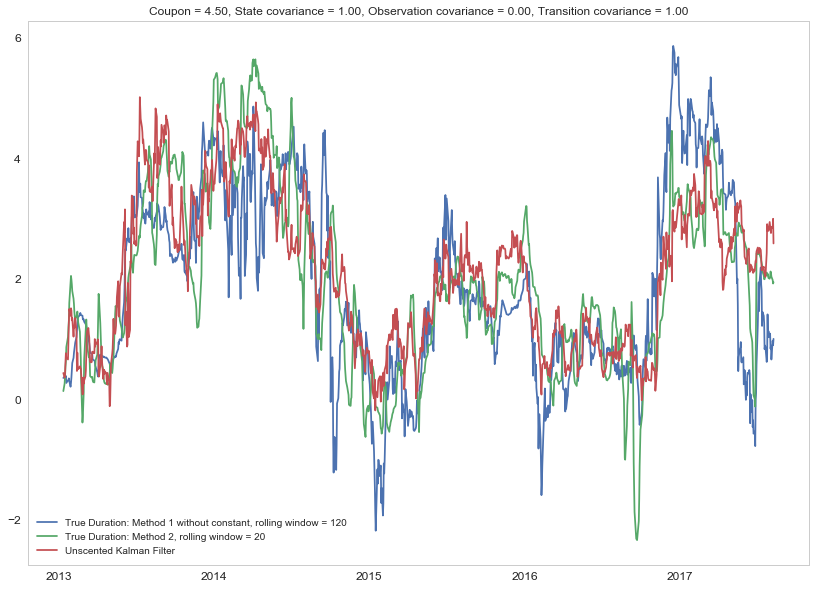

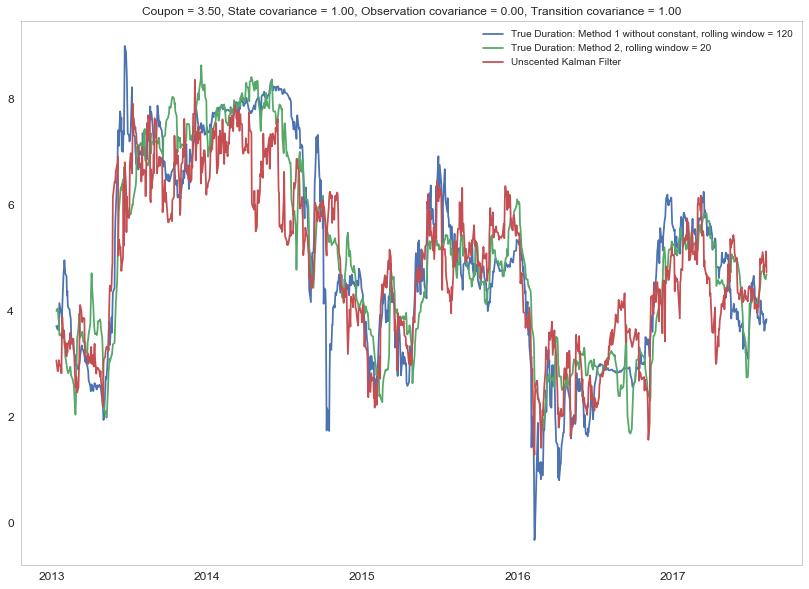

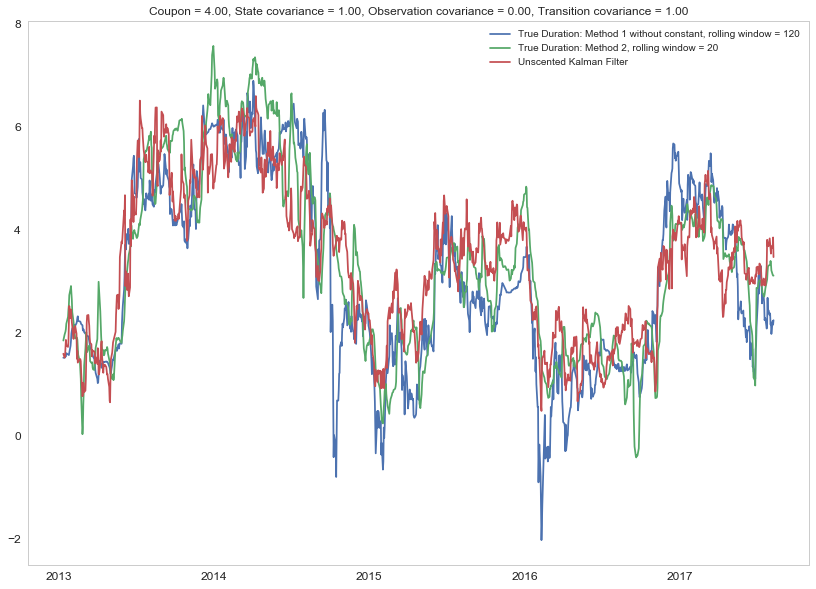

In [465]:
all_rollings_bmk_test_3_5 = getRollingBmkTestAndPlot(all_d_bf_em_3_5)

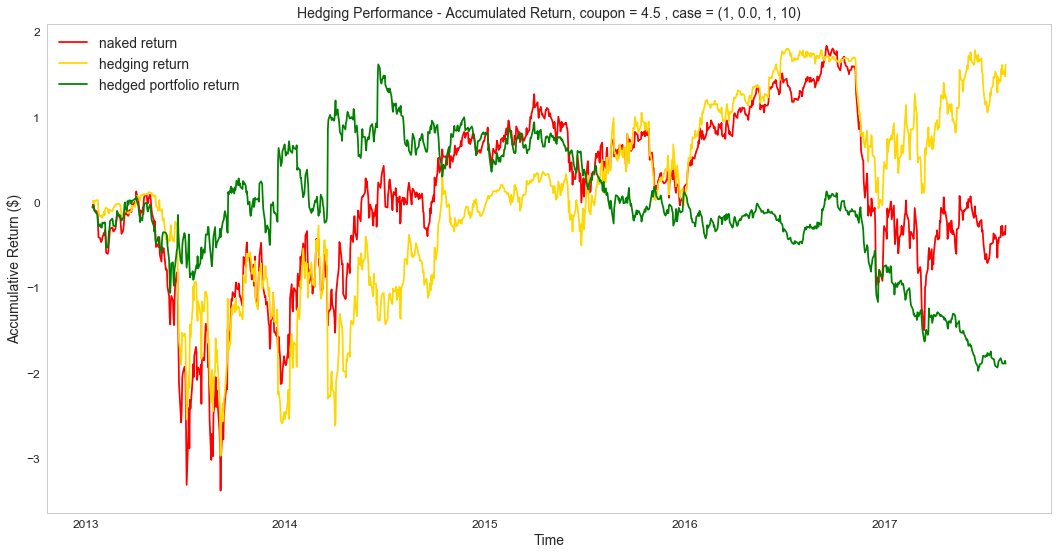

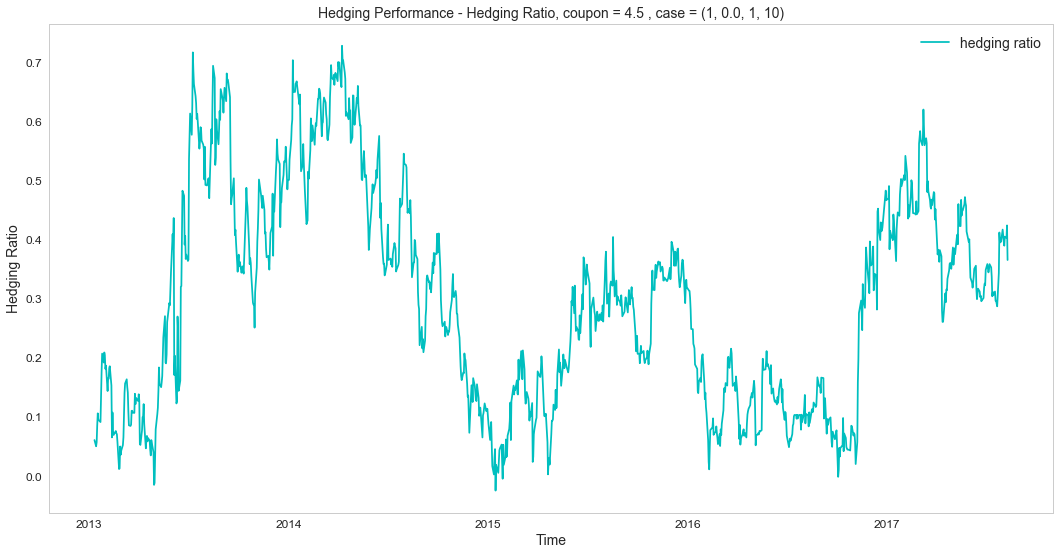

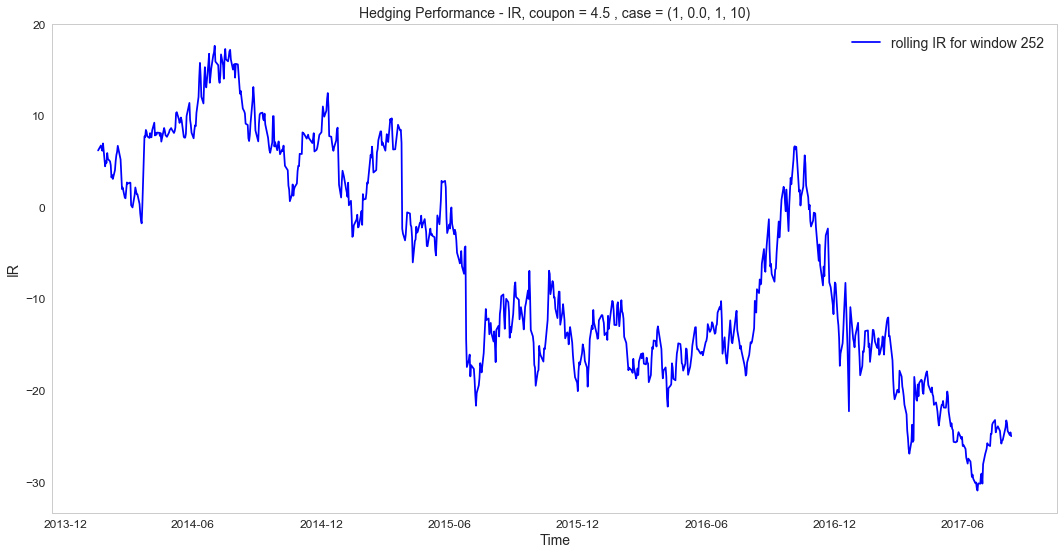

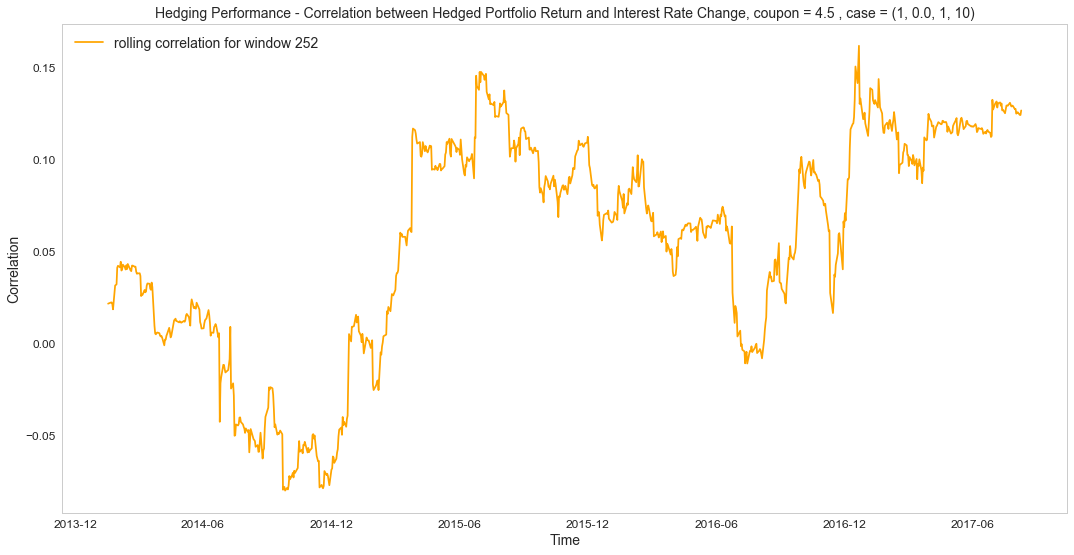

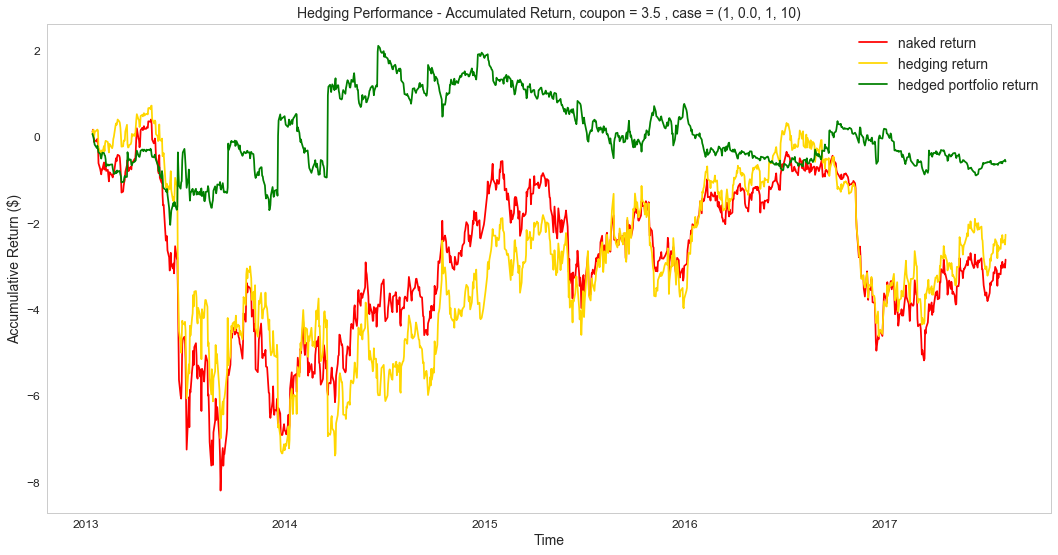

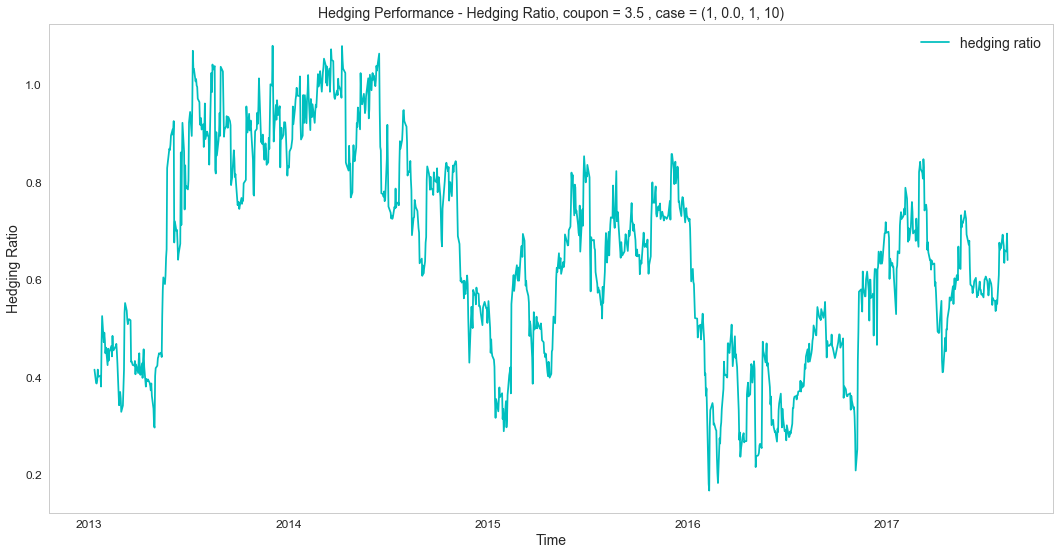

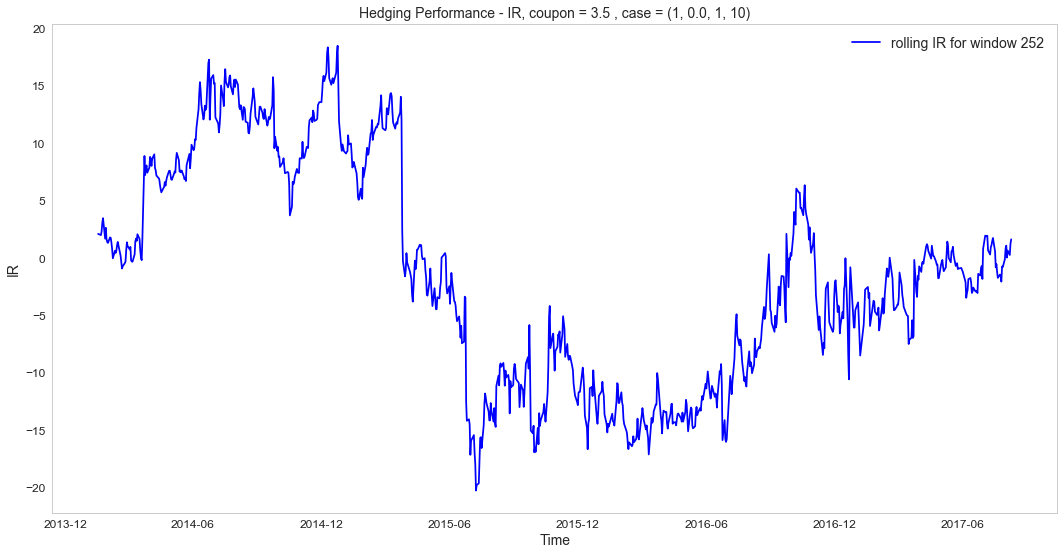

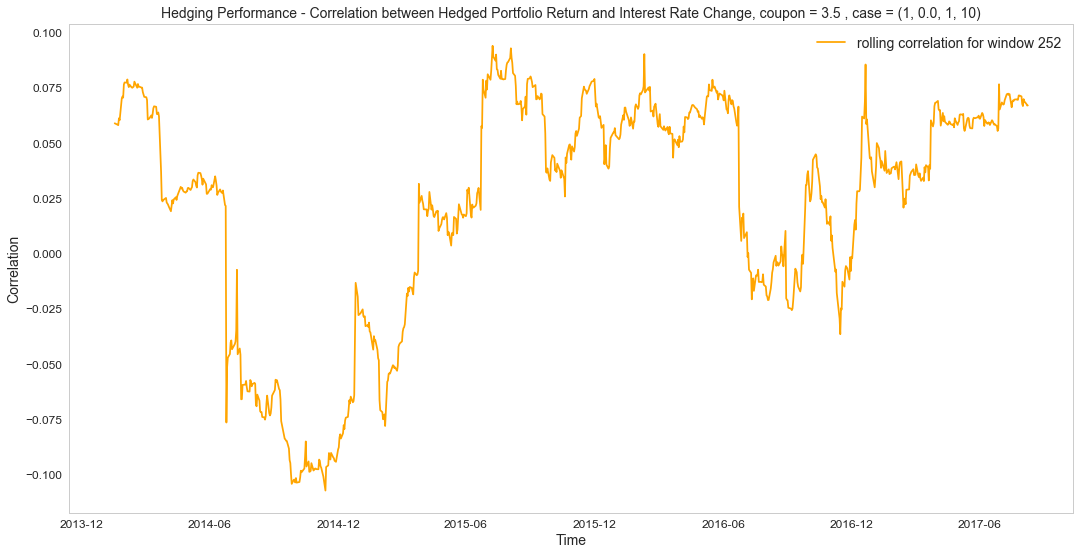

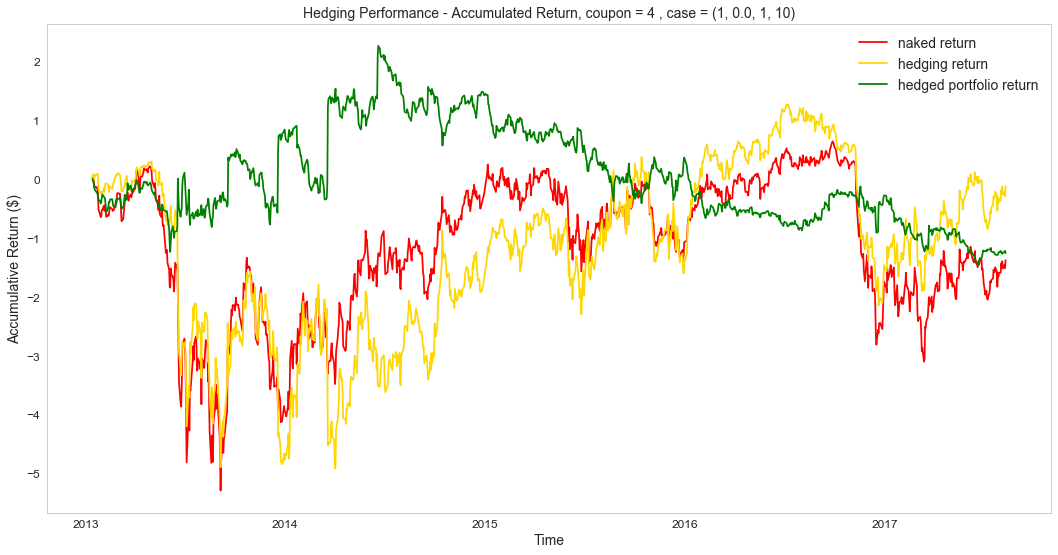

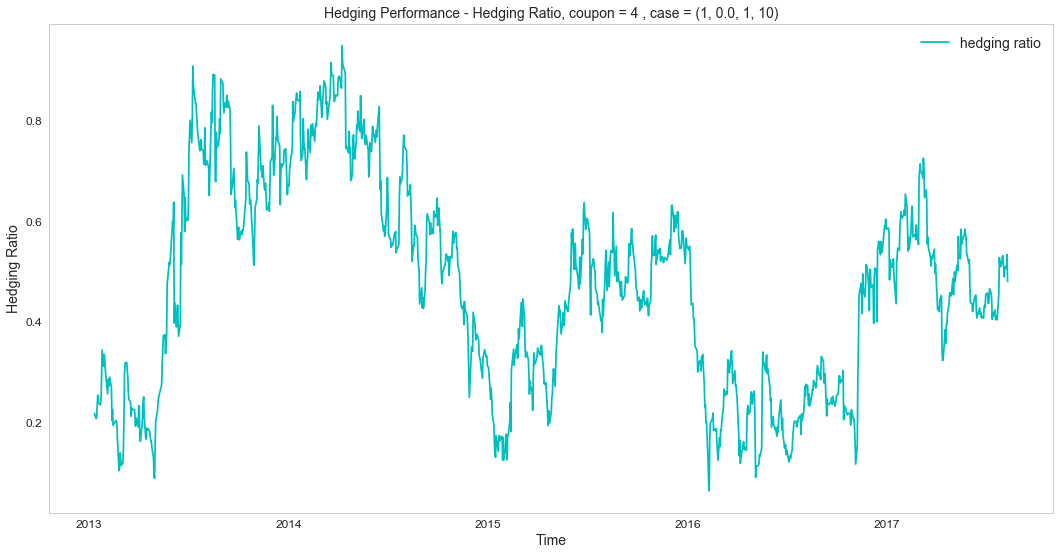

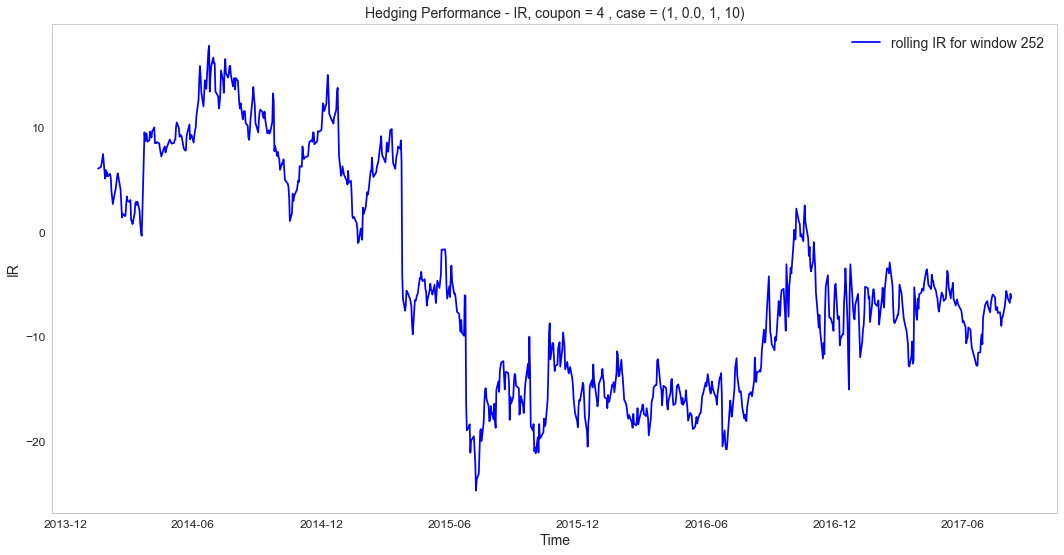

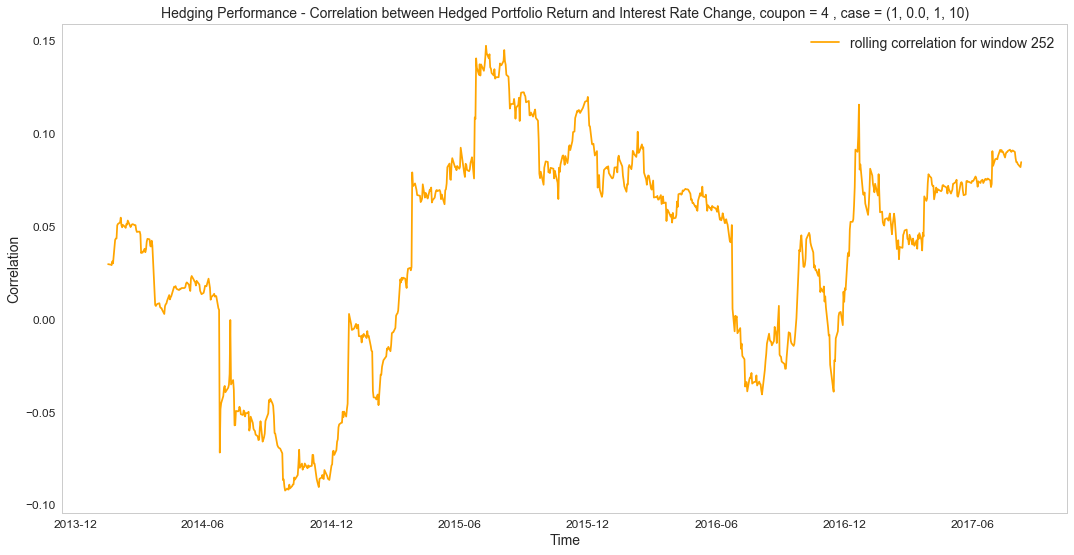

In [466]:
all_hedge_result_m3_5 = getHeggeResultAndPlot(all_rollings_bmk_test_3_5, start_date = '2013-01-11')

In [467]:
hedge_res_3_5 = printHedgeResult(all_hedge_result_m3_5, 'Model_3_5_perf.csv')

     Absolute Difference Mean  Absolute Difference Median  Correlation mean  \
4.0                  0.025265                    0.018097          0.035936   
3.5                  0.028476                    0.019062          0.021264   
4.5                  0.022635                    0.015817          0.055840   

     Correlation std  
4.0         0.057213  
3.5         0.051864  
4.5         0.059527  


# 3.6. Smoothing model

In [ ]:
def getSmoothKF(rolling_res, window_size):
    cov = 0.0001
    all_smooth_beta = {}
    all_smooth_beta_hedge_res = {}
    
    for c in coupons:
        kf = KalmanFilter(initial_state_mean=0,initial_state_covariance=1,
            observation_matrices = 1,
                          transition_matrices = 1,
                          transition_covariance = cov,
                         observation_covariance = 1)

        # state_mean_beta,_ = kf.filter(D_20_wInt)
        state_mean_beta,_ = kf.filter(rolling_res[c])
        KF_1 = pd.DataFrame(state_mean_beta,index=data.index[window_size + 1:])
        all_smooth_beta[c] = KF_1
        # data_merge_for_hedging(dur1,dur2,price1,price2,ten_yr_treasury)

        hedge_info=data_merge_for_hedging(KF_1,fut_dur,pd.DataFrame(TBAs[c]['price']),fut_price,rate_Base)

        # hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
        hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2008-01-01')
        
        all_smooth_beta_hedge_res[c] = hedge_result
        
        np.std(hedge_result['portfolio_corr'])


        t2 = [np.mean(hedge_result['portfolio_corr']), \
              np.std(hedge_result['portfolio_corr']),np.mean(np.abs(np.diff(hedge_result['hedge_ratio']))),
             np.median(np.abs(np.diff(hedge_result['hedge_ratio'])))]
        print('coupon = ', c)
        print("metrix1: ", np.mean(hedge_result['portfolio_corr']))
        print("metrix2: ", np.std(hedge_result['portfolio_corr']))
        print("metrix3: ", np.mean(np.abs(np.diff(hedge_result['hedge_ratio']))))
        
    return all_smooth_beta, all_smooth_beta_hedge_res

In [ ]:
all_smooth_beta_20, all_smooth_beta_hedge_res_20 = getSmoothKF(all_D_20_woInt, 20)

In [ ]:
def getSmoothingModelHedgeResultAndPlot(rolling_res, window_size, file_name):
    all_hedge_res = {}
    
    corr_mean = []
    corr_std = []
    ratio_diff_mean = []
    ratio_diff_median = []
    cs = []
    
    for c in coupons:
        #D_120 = pd.DataFrame(all_D_120_woInt[c],index=all_data[c].index[window_120 + 1:])
        D_tmp = pd.DataFrame(rolling_res[c],index=all_data[c].index[window_size + 1:])

        hedge_info=data_merge_for_hedging(D_tmp,fut_dur,pd.DataFrame(TBAs[c]['price']),fut_price,rate_Base)

        # hedge_perform(hedge_info,window,notional=100,startDate=np.nan)
        hedge_result=hedge_perform(hedge_info,252,notional=100,startDate='2013-01-11')

        all_hedge_res[c] = hedge_result
        
        t0 = [np.mean(hedge_result['portfolio_corr']), \
              np.std(hedge_result['portfolio_corr']),\
              np.mean(np.abs(np.diff(hedge_result['hedge_ratio']))),\
                np.median(np.abs(np.diff(hedge_result['hedge_ratio'])))]
        print('coupon : ', c)
        print("metrix1: ", np.mean(hedge_result['portfolio_corr']))
        print("metrix2: ", np.std(hedge_result['portfolio_corr']))
        print("metrix3: ", np.mean(np.abs(np.diff(hedge_result['hedge_ratio']))))
        
        corr_mean.append(np.mean(hedge_result['portfolio_corr']))
        corr_std.append(np.std(hedge_result['portfolio_corr']))
        ratio_diff_mean.append(np.mean(np.abs(np.diff(hedge_result['hedge_ratio']))))
        ratio_diff_median.append(np.median(np.abs(np.diff(hedge_result['hedge_ratio']))))
        cs.append(c)
    
    perf_mat = pd.DataFrame({
        'Correlation mean' : corr_mean,
        'Correlation std' : corr_std,
        'Absolute Difference Mean' : ratio_diff_mean,
        'Absolute Difference Median' : ratio_diff_median
    }, index = cs)

    perf_mat.to_csv(file_name)
    print(perf_mat)
    return perf_mat, all_hedge_res

In [ ]:
perf_mat_D20, all_hedge_res_smooth = getSmoothingModelHedgeResultAndPlot(all_smooth_beta_20, window_20, 'smoothing_D20.csv')

# 4. Plot

In [ ]:
def getHeggeResultAndPlotRollingRegression(all_rollings_bmk, col, start_date):
    all_hedge_result = {}
    for c, rollings_bmk_test in all_rollings_bmk.items():
        hedge_info=data_merge_for_hedging(pd.DataFrame(rollings_bmk_test[col]),fut_dur,pd.DataFrame(TBAs[c]['price']),fut_price,rate_Base)

        hedge_result=hedge_perform(hedge_info,252,notional=100,startDate=start_date, title = 'coupon = ' + str(c) + ' , ' + col)
        all_hedge_result[c] = hedge_result
    return all_hedge_result

In [ ]:
all_hedge_res_D_20_woInt = getHeggeResultAndPlotRollingRegression(all_rollings_bmk, 'D_20_woInt', start_date = '2013-01-11')

In [ ]:
hedge_res_D20 = printHedgeResult(all_hedge_res_D_20_woInt, 'all_hedge_res_D_20_woInt.csv')

In [ ]:
all_hedge_res_D_120_woInt = getHeggeResultAndPlotRollingRegression(all_rollings_bmk, 'D_120_woInt', start_date = '2013-01-11')

In [ ]:
hedge_res_D120 = printHedgeResult(all_hedge_res_D_120_woInt, 'all_hedge_res_D_120_woInt.csv')

In [ ]:
for i, c in enumerate(coupons, 1):
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot(111)
    ax.plot(all_D_20_woInt[c]['2013-01-11':], label = 'Rolling regression, window = 20')
    ax.plot(all_D_120_woInt[c]['2013-01-11':], label = 'Rolling regression, window = 120')
    ax.plot(all_smooth_beta_20[c]['2013-01-11':], label = 'KF Smoothed Duration')
    ax.plot(all_rollings_bmk_test_3_2[c].iloc[:, 5], label = r'KF $\frac{\Delta price}{price} = - duration_t * \Delta rate + c$')
    ax.plot(all_rollings_bmk_test_3_4[c].iloc[:, 5], label = r'KF $price = \alpha_t + \beta_t * rate + \gamma_t * rate^2$')
    ax.set_title('Coupon = ' + str(c))
    ax.set_ylabel('Duration')
    ax.legend()
    plt.savefig('all duration' + str(c) + '.png')

### Hedging ratio

In [ ]:
def outputHedgeResultImage(col, name, start_date = default_start_date):
    hedge_res_set = [all_hedge_result_m3_2, all_hedge_res_D_120_woInt, all_smooth_beta_hedge_res_20]
    hedge_res_label = [r'$\frac{\Delta price}{price} = - duration_t * \Delta rate + c$', 'Rolling Regression, window = 120', 'KF Smoothing']
    for c in coupons:
        fig = plt.figure(figsize = (16, 10))
        ax = fig.add_subplot(111)
        for i, hr in enumerate(hedge_res_set):
            ax.plot(hr[c][start_date:][col], label = hedge_res_label[i])
        ax.legend()
        ax.set_ylabel(name)
        ax.set_title(name + ' for coupon ' + str(c))
        plt.savefig(name + ' ' + str(c) + '.png')

In [ ]:
all_hedge_result_m3_2[3.5].columns

In [ ]:
outputHedgeResultImage('hedge_ratio', 'Hedge ratio')

In [ ]:
outputHedgeResultImage('portfolio_corr', 'Portfolio correlation', start_date = '2013-12-01')